In [1]:
import pandas as pd
import json
import os
import math
import numpy as np
import librosa, librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
#loading the data
df = pd.read_csv("Data/features_3_sec.csv")
df.head(10)

In [6]:
#reading the data
print("Dataset has",df.shape)
print("total Positive and Negative samples")
df.label.value_counts().reset_index()

Dataset has (9990, 60)
total Positive and Negative samples


,index,label
0,jazz,1000
1,pop,1000
2,metal,1000
3,blues,1000
4,reggae,1000
5,disco,999
6,rock,998
7,hiphop,998
8,classical,998
9,country,997


In [ ]:
df.dtypes

In [8]:
df = df.drop(labels="filename", axis=1)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5]),
 [Text(0, 0.5, 'chroma_stft_mean'),
  Text(0, 1.5, 'rms_mean'),
  Text(0, 2.5, 'spectral_centroid_mean'),
  Text(0, 3.5, 'spectral_bandwidth_mean'),
  Text(0, 4.5, 'rolloff_mean'),
  Text(0, 5.5, 'zero_crossing_rate_mean'),
  Text(0, 6.5, 'harmony_mean'),
  Text(0, 7.5, 'perceptr_mean'),
  Text(0, 8.5, 'mfcc1_mean'),
  Text(0, 9.5, 'mfcc2_mean'),
  Text(0, 10.5, 'mfcc3_mean'),
  Text(0, 11.5, 'mfcc4_mean'),
  Text(0, 12.5, 'mfcc5_mean'),
  Text(0, 13.5, 'mfcc6_mean'),
  Text(0, 14.5, 'mfcc7_mean'),
  Text(0, 15.5, 'mfcc8_mean'),
  Text(0, 16.5, 'mfcc9_mean'),
  Text(0, 17.5, 'mfcc10_mean'),
  Text(0, 18.5, 'mfcc11_mean'),
  Text(0, 19.5, 'mfcc12_mean'),
  Text(0, 20.5, 'mfcc13_mean'),
  Text(0, 21.5, 'mfcc14_mean'),
  Text(0, 22.5, 'mfcc15_mean'),
  Text(0, 23.5, 'mfcc16_mean'),
  Text(0, 24.5, 

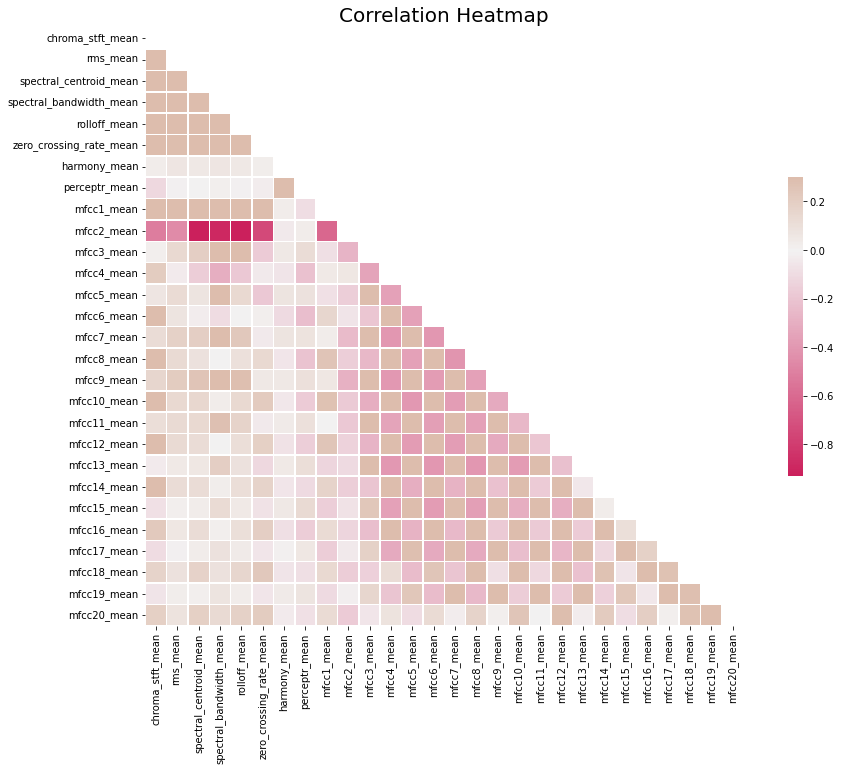

In [9]:
#visalizing the data
import seaborn as sns
import matplotlib.pyplot as plt
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)


Text(0, 0.5, 'BPM')

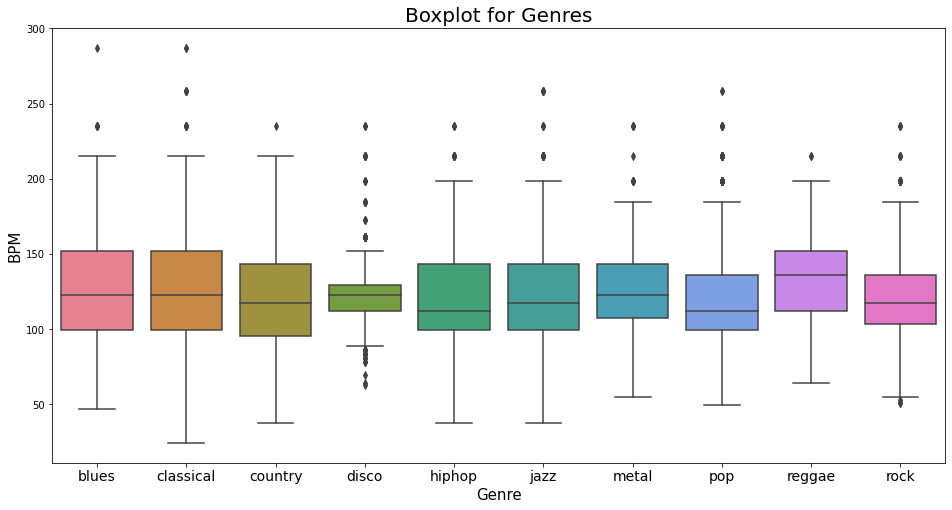

In [10]:
x = df[["label", "tempo"]]
fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');
plt.title('Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)

Text(0, 0.5, 'Principal Component 2')

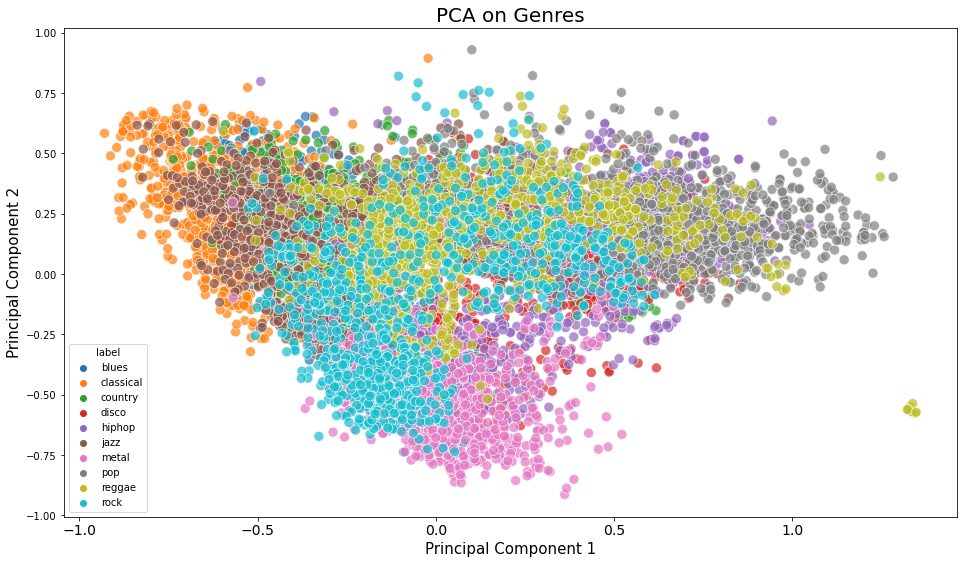

In [11]:
import sklearn.preprocessing as skp
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Top 2 pca components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)

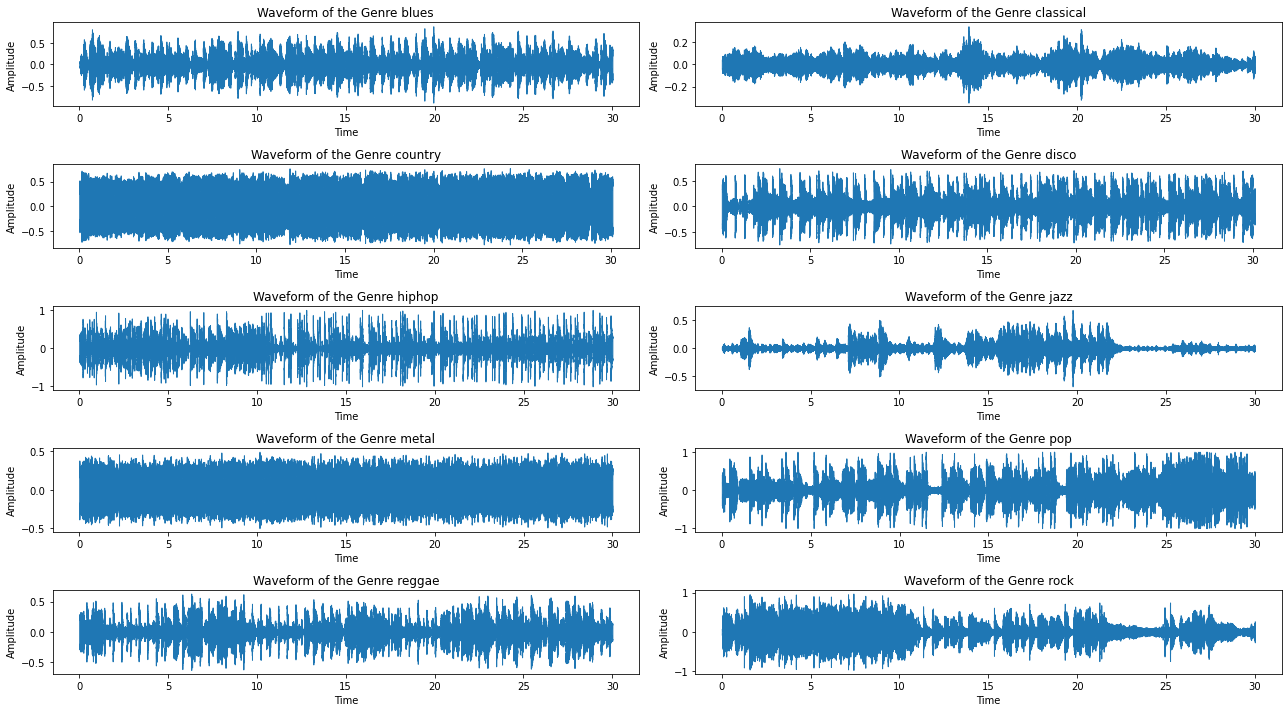

In [12]:
base_path = 'Data/genres_original/'

# List of genre folders
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Create a figure for plotting
plt.figure(figsize=(18, 10))

# Loop through each genre and plot the waveform
for i, genre in enumerate(genres):
    # Get the list of audio files in the genre folder
    genre_folder = os.path.join(base_path, genre)
    audio_files = os.listdir(genre_folder)

    # Plot the first audio file in the genre
    path = os.path.join(genre_folder, audio_files[0])

    plt.subplot(5, 2, i + 1)
    x, sr = librosa.load(path)
    librosa.display.waveshow(x, sr=sr)

    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(f'Waveform of the Genre {genre}')

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

In [13]:
#building the model
#following models will be tested: CNN, DNN and RNN

In [4]:
DATASET_PATH = "Data/genres_original"
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


In [5]:
#Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        #:param dataset_path (str): Path to dataset
        #:param json_path (str): Path to json file used to save MFCCs
        #:param num_mfcc (int): Number of coefficients to extract
       # :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
       # :param hop_length (int): Sliding window for FFT. Measured in # of samples
      #   :param: num_segments (int): Number of segments we want to divide sample tracks into
      # :return:

def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensure we're processing a genre sub-folder level
        if dirpath != dataset_path:
            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = os.path.basename(dirpath)
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                
                # Skip problematic files (e.g., jazz.00054.wav)
                if file_path.endswith('jazz.00054.wav'):
                    continue

                try:
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
                    continue

                # process all segments of audio file
                for d in range(num_segments):
                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(
                        y=signal[start:finish],
                        sr=sample_rate,
                        n_mfcc=num_mfcc,
                        n_fft=n_fft,
                        hop_length=hop_length
                    )
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i - 1)
                        print("{}, segment:{}".format(file_path, d + 1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
    print(f"Data saved to {json_path}")


In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

Data/genres_original\blues\blues.00015.wav, segment:7
Data/genres_original\blues\blues.00015.wav, segment:8
Data/genres_original\blues\blues.00015.wav, segment:9
Data/genres_original\blues\blues.00015.wav, segment:10
Data/genres_original\blues\blues.00016.wav, segment:1
Data/genres_original\blues\blues.00016.wav, segment:2
Data/genres_original\blues\blues.00016.wav, segment:3
Data/genres_original\blues\blues.00016.wav, segment:4
Data/genres_original\blues\blues.00016.wav, segment:5
Data/genres_original\blues\blues.00016.wav, segment:6
Data/genres_original\blues\blues.00016.wav, segment:7
Data/genres_original\blues\blues.00016.wav, segment:8
Data/genres_original\blues\blues.00016.wav, segment:9
Data/genres_original\blues\blues.00016.wav, segment:10
Data/genres_original\blues\blues.00017.wav, segment:1
Data/genres_original\blues\blues.00017.wav, segment:2
Data/genres_original\blues\blues.00017.wav, segment:3
Data/genres_original\blues\blues.00017.wav, segment:4
Data/genres_original\blues

Data/genres_original\blues\blues.00033.wav, segment:2
Data/genres_original\blues\blues.00033.wav, segment:3
Data/genres_original\blues\blues.00033.wav, segment:4
Data/genres_original\blues\blues.00033.wav, segment:5
Data/genres_original\blues\blues.00033.wav, segment:6
Data/genres_original\blues\blues.00033.wav, segment:7
Data/genres_original\blues\blues.00033.wav, segment:8
Data/genres_original\blues\blues.00033.wav, segment:9
Data/genres_original\blues\blues.00033.wav, segment:10
Data/genres_original\blues\blues.00034.wav, segment:1
Data/genres_original\blues\blues.00034.wav, segment:2
Data/genres_original\blues\blues.00034.wav, segment:3
Data/genres_original\blues\blues.00034.wav, segment:4
Data/genres_original\blues\blues.00034.wav, segment:5
Data/genres_original\blues\blues.00034.wav, segment:6
Data/genres_original\blues\blues.00034.wav, segment:7
Data/genres_original\blues\blues.00034.wav, segment:8
Data/genres_original\blues\blues.00034.wav, segment:9
Data/genres_original\blues\

Data/genres_original\blues\blues.00048.wav, segment:5
Data/genres_original\blues\blues.00048.wav, segment:6
Data/genres_original\blues\blues.00048.wav, segment:7
Data/genres_original\blues\blues.00048.wav, segment:8
Data/genres_original\blues\blues.00048.wav, segment:9
Data/genres_original\blues\blues.00048.wav, segment:10
Data/genres_original\blues\blues.00049.wav, segment:1
Data/genres_original\blues\blues.00049.wav, segment:2
Data/genres_original\blues\blues.00049.wav, segment:3
Data/genres_original\blues\blues.00049.wav, segment:4
Data/genres_original\blues\blues.00049.wav, segment:5
Data/genres_original\blues\blues.00049.wav, segment:6
Data/genres_original\blues\blues.00049.wav, segment:7
Data/genres_original\blues\blues.00049.wav, segment:8
Data/genres_original\blues\blues.00049.wav, segment:9
Data/genres_original\blues\blues.00049.wav, segment:10
Data/genres_original\blues\blues.00050.wav, segment:1
Data/genres_original\blues\blues.00050.wav, segment:2
Data/genres_original\blues

Data/genres_original\blues\blues.00064.wav, segment:1
Data/genres_original\blues\blues.00064.wav, segment:2
Data/genres_original\blues\blues.00064.wav, segment:3
Data/genres_original\blues\blues.00064.wav, segment:4
Data/genres_original\blues\blues.00064.wav, segment:5
Data/genres_original\blues\blues.00064.wav, segment:6
Data/genres_original\blues\blues.00064.wav, segment:7
Data/genres_original\blues\blues.00064.wav, segment:8
Data/genres_original\blues\blues.00064.wav, segment:9
Data/genres_original\blues\blues.00064.wav, segment:10
Data/genres_original\blues\blues.00065.wav, segment:1
Data/genres_original\blues\blues.00065.wav, segment:2
Data/genres_original\blues\blues.00065.wav, segment:3
Data/genres_original\blues\blues.00065.wav, segment:4
Data/genres_original\blues\blues.00065.wav, segment:5
Data/genres_original\blues\blues.00065.wav, segment:6
Data/genres_original\blues\blues.00065.wav, segment:7
Data/genres_original\blues\blues.00065.wav, segment:8
Data/genres_original\blues\

Data/genres_original\blues\blues.00079.wav, segment:3
Data/genres_original\blues\blues.00079.wav, segment:4
Data/genres_original\blues\blues.00079.wav, segment:5
Data/genres_original\blues\blues.00079.wav, segment:6
Data/genres_original\blues\blues.00079.wav, segment:7
Data/genres_original\blues\blues.00079.wav, segment:8
Data/genres_original\blues\blues.00079.wav, segment:9
Data/genres_original\blues\blues.00079.wav, segment:10
Data/genres_original\blues\blues.00080.wav, segment:1
Data/genres_original\blues\blues.00080.wav, segment:2
Data/genres_original\blues\blues.00080.wav, segment:3
Data/genres_original\blues\blues.00080.wav, segment:4
Data/genres_original\blues\blues.00080.wav, segment:5
Data/genres_original\blues\blues.00080.wav, segment:6
Data/genres_original\blues\blues.00080.wav, segment:7
Data/genres_original\blues\blues.00080.wav, segment:8
Data/genres_original\blues\blues.00080.wav, segment:9
Data/genres_original\blues\blues.00080.wav, segment:10
Data/genres_original\blues

Data/genres_original\blues\blues.00096.wav, segment:8
Data/genres_original\blues\blues.00096.wav, segment:9
Data/genres_original\blues\blues.00096.wav, segment:10
Data/genres_original\blues\blues.00097.wav, segment:1
Data/genres_original\blues\blues.00097.wav, segment:2
Data/genres_original\blues\blues.00097.wav, segment:3
Data/genres_original\blues\blues.00097.wav, segment:4
Data/genres_original\blues\blues.00097.wav, segment:5
Data/genres_original\blues\blues.00097.wav, segment:6
Data/genres_original\blues\blues.00097.wav, segment:7
Data/genres_original\blues\blues.00097.wav, segment:8
Data/genres_original\blues\blues.00097.wav, segment:9
Data/genres_original\blues\blues.00097.wav, segment:10
Data/genres_original\blues\blues.00098.wav, segment:1
Data/genres_original\blues\blues.00098.wav, segment:2
Data/genres_original\blues\blues.00098.wav, segment:3
Data/genres_original\blues\blues.00098.wav, segment:4
Data/genres_original\blues\blues.00098.wav, segment:5
Data/genres_original\blues

Data/genres_original\classical\classical.00011.wav, segment:9
Data/genres_original\classical\classical.00011.wav, segment:10
Data/genres_original\classical\classical.00012.wav, segment:1
Data/genres_original\classical\classical.00012.wav, segment:2
Data/genres_original\classical\classical.00012.wav, segment:3
Data/genres_original\classical\classical.00012.wav, segment:4
Data/genres_original\classical\classical.00012.wav, segment:5
Data/genres_original\classical\classical.00012.wav, segment:6
Data/genres_original\classical\classical.00012.wav, segment:7
Data/genres_original\classical\classical.00012.wav, segment:8
Data/genres_original\classical\classical.00012.wav, segment:9
Data/genres_original\classical\classical.00012.wav, segment:10
Data/genres_original\classical\classical.00013.wav, segment:1
Data/genres_original\classical\classical.00013.wav, segment:2
Data/genres_original\classical\classical.00013.wav, segment:3
Data/genres_original\classical\classical.00013.wav, segment:4
Data/g

Data/genres_original\classical\classical.00027.wav, segment:8
Data/genres_original\classical\classical.00027.wav, segment:9
Data/genres_original\classical\classical.00027.wav, segment:10
Data/genres_original\classical\classical.00028.wav, segment:1
Data/genres_original\classical\classical.00028.wav, segment:2
Data/genres_original\classical\classical.00028.wav, segment:3
Data/genres_original\classical\classical.00028.wav, segment:4
Data/genres_original\classical\classical.00028.wav, segment:5
Data/genres_original\classical\classical.00028.wav, segment:6
Data/genres_original\classical\classical.00028.wav, segment:7
Data/genres_original\classical\classical.00028.wav, segment:8
Data/genres_original\classical\classical.00028.wav, segment:9
Data/genres_original\classical\classical.00028.wav, segment:10
Data/genres_original\classical\classical.00029.wav, segment:1
Data/genres_original\classical\classical.00029.wav, segment:2
Data/genres_original\classical\classical.00029.wav, segment:3
Data/g

Data/genres_original\classical\classical.00041.wav, segment:6
Data/genres_original\classical\classical.00041.wav, segment:7
Data/genres_original\classical\classical.00041.wav, segment:8
Data/genres_original\classical\classical.00041.wav, segment:9
Data/genres_original\classical\classical.00041.wav, segment:10
Data/genres_original\classical\classical.00042.wav, segment:1
Data/genres_original\classical\classical.00042.wav, segment:2
Data/genres_original\classical\classical.00042.wav, segment:3
Data/genres_original\classical\classical.00042.wav, segment:4
Data/genres_original\classical\classical.00042.wav, segment:5
Data/genres_original\classical\classical.00042.wav, segment:6
Data/genres_original\classical\classical.00042.wav, segment:7
Data/genres_original\classical\classical.00042.wav, segment:8
Data/genres_original\classical\classical.00042.wav, segment:9
Data/genres_original\classical\classical.00042.wav, segment:10
Data/genres_original\classical\classical.00043.wav, segment:1
Data/g

Data/genres_original\classical\classical.00055.wav, segment:7
Data/genres_original\classical\classical.00055.wav, segment:8
Data/genres_original\classical\classical.00055.wav, segment:9
Data/genres_original\classical\classical.00055.wav, segment:10
Data/genres_original\classical\classical.00056.wav, segment:1
Data/genres_original\classical\classical.00056.wav, segment:2
Data/genres_original\classical\classical.00056.wav, segment:3
Data/genres_original\classical\classical.00056.wav, segment:4
Data/genres_original\classical\classical.00056.wav, segment:5
Data/genres_original\classical\classical.00056.wav, segment:6
Data/genres_original\classical\classical.00056.wav, segment:7
Data/genres_original\classical\classical.00056.wav, segment:8
Data/genres_original\classical\classical.00056.wav, segment:9
Data/genres_original\classical\classical.00056.wav, segment:10
Data/genres_original\classical\classical.00057.wav, segment:1
Data/genres_original\classical\classical.00057.wav, segment:2
Data/g

Data/genres_original\classical\classical.00070.wav, segment:2
Data/genres_original\classical\classical.00070.wav, segment:3
Data/genres_original\classical\classical.00070.wav, segment:4
Data/genres_original\classical\classical.00070.wav, segment:5
Data/genres_original\classical\classical.00070.wav, segment:6
Data/genres_original\classical\classical.00070.wav, segment:7
Data/genres_original\classical\classical.00070.wav, segment:8
Data/genres_original\classical\classical.00070.wav, segment:9
Data/genres_original\classical\classical.00070.wav, segment:10
Data/genres_original\classical\classical.00071.wav, segment:1
Data/genres_original\classical\classical.00071.wav, segment:2
Data/genres_original\classical\classical.00071.wav, segment:3
Data/genres_original\classical\classical.00071.wav, segment:4
Data/genres_original\classical\classical.00071.wav, segment:5
Data/genres_original\classical\classical.00071.wav, segment:6
Data/genres_original\classical\classical.00071.wav, segment:7
Data/ge

Data/genres_original\classical\classical.00086.wav, segment:2
Data/genres_original\classical\classical.00086.wav, segment:3
Data/genres_original\classical\classical.00086.wav, segment:4
Data/genres_original\classical\classical.00086.wav, segment:5
Data/genres_original\classical\classical.00086.wav, segment:6
Data/genres_original\classical\classical.00086.wav, segment:7
Data/genres_original\classical\classical.00086.wav, segment:8
Data/genres_original\classical\classical.00086.wav, segment:9
Data/genres_original\classical\classical.00086.wav, segment:10
Data/genres_original\classical\classical.00087.wav, segment:1
Data/genres_original\classical\classical.00087.wav, segment:2
Data/genres_original\classical\classical.00087.wav, segment:3
Data/genres_original\classical\classical.00087.wav, segment:4
Data/genres_original\classical\classical.00087.wav, segment:5
Data/genres_original\classical\classical.00087.wav, segment:6
Data/genres_original\classical\classical.00087.wav, segment:7
Data/ge

Data/genres_original\classical\classical.00099.wav, segment:7
Data/genres_original\classical\classical.00099.wav, segment:8
Data/genres_original\classical\classical.00099.wav, segment:9
Data/genres_original\classical\classical.00099.wav, segment:10

Processing: country
Data/genres_original\country\country.00000.wav, segment:1
Data/genres_original\country\country.00000.wav, segment:2
Data/genres_original\country\country.00000.wav, segment:3
Data/genres_original\country\country.00000.wav, segment:4
Data/genres_original\country\country.00000.wav, segment:5
Data/genres_original\country\country.00000.wav, segment:6
Data/genres_original\country\country.00000.wav, segment:7
Data/genres_original\country\country.00000.wav, segment:8
Data/genres_original\country\country.00000.wav, segment:9
Data/genres_original\country\country.00000.wav, segment:10
Data/genres_original\country\country.00001.wav, segment:1
Data/genres_original\country\country.00001.wav, segment:2
Data/genres_original\country\coun

Data/genres_original\country\country.00016.wav, segment:4
Data/genres_original\country\country.00016.wav, segment:5
Data/genres_original\country\country.00016.wav, segment:6
Data/genres_original\country\country.00016.wav, segment:7
Data/genres_original\country\country.00016.wav, segment:8
Data/genres_original\country\country.00016.wav, segment:9
Data/genres_original\country\country.00016.wav, segment:10
Data/genres_original\country\country.00017.wav, segment:1
Data/genres_original\country\country.00017.wav, segment:2
Data/genres_original\country\country.00017.wav, segment:3
Data/genres_original\country\country.00017.wav, segment:4
Data/genres_original\country\country.00017.wav, segment:5
Data/genres_original\country\country.00017.wav, segment:6
Data/genres_original\country\country.00017.wav, segment:7
Data/genres_original\country\country.00017.wav, segment:8
Data/genres_original\country\country.00017.wav, segment:9
Data/genres_original\country\country.00017.wav, segment:10
Data/genres_

Data/genres_original\country\country.00032.wav, segment:2
Data/genres_original\country\country.00032.wav, segment:3
Data/genres_original\country\country.00032.wav, segment:4
Data/genres_original\country\country.00032.wav, segment:5
Data/genres_original\country\country.00032.wav, segment:6
Data/genres_original\country\country.00032.wav, segment:7
Data/genres_original\country\country.00032.wav, segment:8
Data/genres_original\country\country.00032.wav, segment:9
Data/genres_original\country\country.00032.wav, segment:10
Data/genres_original\country\country.00033.wav, segment:1
Data/genres_original\country\country.00033.wav, segment:2
Data/genres_original\country\country.00033.wav, segment:3
Data/genres_original\country\country.00033.wav, segment:4
Data/genres_original\country\country.00033.wav, segment:5
Data/genres_original\country\country.00033.wav, segment:6
Data/genres_original\country\country.00033.wav, segment:7
Data/genres_original\country\country.00033.wav, segment:8
Data/genres_o

Data/genres_original\country\country.00047.wav, segment:8
Data/genres_original\country\country.00047.wav, segment:9
Data/genres_original\country\country.00047.wav, segment:10
Data/genres_original\country\country.00048.wav, segment:1
Data/genres_original\country\country.00048.wav, segment:2
Data/genres_original\country\country.00048.wav, segment:3
Data/genres_original\country\country.00048.wav, segment:4
Data/genres_original\country\country.00048.wav, segment:5
Data/genres_original\country\country.00048.wav, segment:6
Data/genres_original\country\country.00048.wav, segment:7
Data/genres_original\country\country.00048.wav, segment:8
Data/genres_original\country\country.00048.wav, segment:9
Data/genres_original\country\country.00048.wav, segment:10
Data/genres_original\country\country.00049.wav, segment:1
Data/genres_original\country\country.00049.wav, segment:2
Data/genres_original\country\country.00049.wav, segment:3
Data/genres_original\country\country.00049.wav, segment:4
Data/genres_

Data/genres_original\country\country.00063.wav, segment:6
Data/genres_original\country\country.00063.wav, segment:7
Data/genres_original\country\country.00063.wav, segment:8
Data/genres_original\country\country.00063.wav, segment:9
Data/genres_original\country\country.00063.wav, segment:10
Data/genres_original\country\country.00064.wav, segment:1
Data/genres_original\country\country.00064.wav, segment:2
Data/genres_original\country\country.00064.wav, segment:3
Data/genres_original\country\country.00064.wav, segment:4
Data/genres_original\country\country.00064.wav, segment:5
Data/genres_original\country\country.00064.wav, segment:6
Data/genres_original\country\country.00064.wav, segment:7
Data/genres_original\country\country.00064.wav, segment:8
Data/genres_original\country\country.00064.wav, segment:9
Data/genres_original\country\country.00064.wav, segment:10
Data/genres_original\country\country.00065.wav, segment:1
Data/genres_original\country\country.00065.wav, segment:2
Data/genres_

Data/genres_original\country\country.00079.wav, segment:10
Data/genres_original\country\country.00080.wav, segment:1
Data/genres_original\country\country.00080.wav, segment:2
Data/genres_original\country\country.00080.wav, segment:3
Data/genres_original\country\country.00080.wav, segment:4
Data/genres_original\country\country.00080.wav, segment:5
Data/genres_original\country\country.00080.wav, segment:6
Data/genres_original\country\country.00080.wav, segment:7
Data/genres_original\country\country.00080.wav, segment:8
Data/genres_original\country\country.00080.wav, segment:9
Data/genres_original\country\country.00080.wav, segment:10
Data/genres_original\country\country.00081.wav, segment:1
Data/genres_original\country\country.00081.wav, segment:2
Data/genres_original\country\country.00081.wav, segment:3
Data/genres_original\country\country.00081.wav, segment:4
Data/genres_original\country\country.00081.wav, segment:5
Data/genres_original\country\country.00081.wav, segment:6
Data/genres_

Data/genres_original\country\country.00096.wav, segment:3
Data/genres_original\country\country.00096.wav, segment:4
Data/genres_original\country\country.00096.wav, segment:5
Data/genres_original\country\country.00096.wav, segment:6
Data/genres_original\country\country.00096.wav, segment:7
Data/genres_original\country\country.00096.wav, segment:8
Data/genres_original\country\country.00096.wav, segment:9
Data/genres_original\country\country.00096.wav, segment:10
Data/genres_original\country\country.00097.wav, segment:1
Data/genres_original\country\country.00097.wav, segment:2
Data/genres_original\country\country.00097.wav, segment:3
Data/genres_original\country\country.00097.wav, segment:4
Data/genres_original\country\country.00097.wav, segment:5
Data/genres_original\country\country.00097.wav, segment:6
Data/genres_original\country\country.00097.wav, segment:7
Data/genres_original\country\country.00097.wav, segment:8
Data/genres_original\country\country.00097.wav, segment:9
Data/genres_o

Data/genres_original\disco\disco.00012.wav, segment:6
Data/genres_original\disco\disco.00012.wav, segment:7
Data/genres_original\disco\disco.00012.wav, segment:8
Data/genres_original\disco\disco.00012.wav, segment:9
Data/genres_original\disco\disco.00012.wav, segment:10
Data/genres_original\disco\disco.00013.wav, segment:1
Data/genres_original\disco\disco.00013.wav, segment:2
Data/genres_original\disco\disco.00013.wav, segment:3
Data/genres_original\disco\disco.00013.wav, segment:4
Data/genres_original\disco\disco.00013.wav, segment:5
Data/genres_original\disco\disco.00013.wav, segment:6
Data/genres_original\disco\disco.00013.wav, segment:7
Data/genres_original\disco\disco.00013.wav, segment:8
Data/genres_original\disco\disco.00013.wav, segment:9
Data/genres_original\disco\disco.00013.wav, segment:10
Data/genres_original\disco\disco.00014.wav, segment:1
Data/genres_original\disco\disco.00014.wav, segment:2
Data/genres_original\disco\disco.00014.wav, segment:3
Data/genres_original\disco

Data/genres_original\disco\disco.00029.wav, segment:3
Data/genres_original\disco\disco.00029.wav, segment:4
Data/genres_original\disco\disco.00029.wav, segment:5
Data/genres_original\disco\disco.00029.wav, segment:6
Data/genres_original\disco\disco.00029.wav, segment:7
Data/genres_original\disco\disco.00029.wav, segment:8
Data/genres_original\disco\disco.00029.wav, segment:9
Data/genres_original\disco\disco.00029.wav, segment:10
Data/genres_original\disco\disco.00030.wav, segment:1
Data/genres_original\disco\disco.00030.wav, segment:2
Data/genres_original\disco\disco.00030.wav, segment:3
Data/genres_original\disco\disco.00030.wav, segment:4
Data/genres_original\disco\disco.00030.wav, segment:5
Data/genres_original\disco\disco.00030.wav, segment:6
Data/genres_original\disco\disco.00030.wav, segment:7
Data/genres_original\disco\disco.00030.wav, segment:8
Data/genres_original\disco\disco.00030.wav, segment:9
Data/genres_original\disco\disco.00030.wav, segment:10
Data/genres_original\disco

Data/genres_original\disco\disco.00047.wav, segment:4
Data/genres_original\disco\disco.00047.wav, segment:5
Data/genres_original\disco\disco.00047.wav, segment:6
Data/genres_original\disco\disco.00047.wav, segment:7
Data/genres_original\disco\disco.00047.wav, segment:8
Data/genres_original\disco\disco.00047.wav, segment:9
Data/genres_original\disco\disco.00047.wav, segment:10
Data/genres_original\disco\disco.00048.wav, segment:1
Data/genres_original\disco\disco.00048.wav, segment:2
Data/genres_original\disco\disco.00048.wav, segment:3
Data/genres_original\disco\disco.00048.wav, segment:4
Data/genres_original\disco\disco.00048.wav, segment:5
Data/genres_original\disco\disco.00048.wav, segment:6
Data/genres_original\disco\disco.00048.wav, segment:7
Data/genres_original\disco\disco.00048.wav, segment:8
Data/genres_original\disco\disco.00048.wav, segment:9
Data/genres_original\disco\disco.00048.wav, segment:10
Data/genres_original\disco\disco.00049.wav, segment:1
Data/genres_original\disco

Data/genres_original\disco\disco.00064.wav, segment:10
Data/genres_original\disco\disco.00065.wav, segment:1
Data/genres_original\disco\disco.00065.wav, segment:2
Data/genres_original\disco\disco.00065.wav, segment:3
Data/genres_original\disco\disco.00065.wav, segment:4
Data/genres_original\disco\disco.00065.wav, segment:5
Data/genres_original\disco\disco.00065.wav, segment:6
Data/genres_original\disco\disco.00065.wav, segment:7
Data/genres_original\disco\disco.00065.wav, segment:8
Data/genres_original\disco\disco.00065.wav, segment:9
Data/genres_original\disco\disco.00065.wav, segment:10
Data/genres_original\disco\disco.00066.wav, segment:1
Data/genres_original\disco\disco.00066.wav, segment:2
Data/genres_original\disco\disco.00066.wav, segment:3
Data/genres_original\disco\disco.00066.wav, segment:4
Data/genres_original\disco\disco.00066.wav, segment:5
Data/genres_original\disco\disco.00066.wav, segment:6
Data/genres_original\disco\disco.00066.wav, segment:7
Data/genres_original\disco

Data/genres_original\disco\disco.00080.wav, segment:8
Data/genres_original\disco\disco.00080.wav, segment:9
Data/genres_original\disco\disco.00080.wav, segment:10
Data/genres_original\disco\disco.00081.wav, segment:1
Data/genres_original\disco\disco.00081.wav, segment:2
Data/genres_original\disco\disco.00081.wav, segment:3
Data/genres_original\disco\disco.00081.wav, segment:4
Data/genres_original\disco\disco.00081.wav, segment:5
Data/genres_original\disco\disco.00081.wav, segment:6
Data/genres_original\disco\disco.00081.wav, segment:7
Data/genres_original\disco\disco.00081.wav, segment:8
Data/genres_original\disco\disco.00081.wav, segment:9
Data/genres_original\disco\disco.00081.wav, segment:10
Data/genres_original\disco\disco.00082.wav, segment:1
Data/genres_original\disco\disco.00082.wav, segment:2
Data/genres_original\disco\disco.00082.wav, segment:3
Data/genres_original\disco\disco.00082.wav, segment:4
Data/genres_original\disco\disco.00082.wav, segment:5
Data/genres_original\disco

Data/genres_original\disco\disco.00096.wav, segment:6
Data/genres_original\disco\disco.00096.wav, segment:7
Data/genres_original\disco\disco.00096.wav, segment:8
Data/genres_original\disco\disco.00096.wav, segment:9
Data/genres_original\disco\disco.00096.wav, segment:10
Data/genres_original\disco\disco.00097.wav, segment:1
Data/genres_original\disco\disco.00097.wav, segment:2
Data/genres_original\disco\disco.00097.wav, segment:3
Data/genres_original\disco\disco.00097.wav, segment:4
Data/genres_original\disco\disco.00097.wav, segment:5
Data/genres_original\disco\disco.00097.wav, segment:6
Data/genres_original\disco\disco.00097.wav, segment:7
Data/genres_original\disco\disco.00097.wav, segment:8
Data/genres_original\disco\disco.00097.wav, segment:9
Data/genres_original\disco\disco.00097.wav, segment:10
Data/genres_original\disco\disco.00098.wav, segment:1
Data/genres_original\disco\disco.00098.wav, segment:2
Data/genres_original\disco\disco.00098.wav, segment:3
Data/genres_original\disco

Data/genres_original\hiphop\hiphop.00013.wav, segment:2
Data/genres_original\hiphop\hiphop.00013.wav, segment:3
Data/genres_original\hiphop\hiphop.00013.wav, segment:4
Data/genres_original\hiphop\hiphop.00013.wav, segment:5
Data/genres_original\hiphop\hiphop.00013.wav, segment:6
Data/genres_original\hiphop\hiphop.00013.wav, segment:7
Data/genres_original\hiphop\hiphop.00013.wav, segment:8
Data/genres_original\hiphop\hiphop.00013.wav, segment:9
Data/genres_original\hiphop\hiphop.00013.wav, segment:10
Data/genres_original\hiphop\hiphop.00014.wav, segment:1
Data/genres_original\hiphop\hiphop.00014.wav, segment:2
Data/genres_original\hiphop\hiphop.00014.wav, segment:3
Data/genres_original\hiphop\hiphop.00014.wav, segment:4
Data/genres_original\hiphop\hiphop.00014.wav, segment:5
Data/genres_original\hiphop\hiphop.00014.wav, segment:6
Data/genres_original\hiphop\hiphop.00014.wav, segment:7
Data/genres_original\hiphop\hiphop.00014.wav, segment:8
Data/genres_original\hiphop\hiphop.00014.wav, s

Data/genres_original\hiphop\hiphop.00029.wav, segment:6
Data/genres_original\hiphop\hiphop.00029.wav, segment:7
Data/genres_original\hiphop\hiphop.00029.wav, segment:8
Data/genres_original\hiphop\hiphop.00029.wav, segment:9
Data/genres_original\hiphop\hiphop.00029.wav, segment:10
Data/genres_original\hiphop\hiphop.00030.wav, segment:1
Data/genres_original\hiphop\hiphop.00030.wav, segment:2
Data/genres_original\hiphop\hiphop.00030.wav, segment:3
Data/genres_original\hiphop\hiphop.00030.wav, segment:4
Data/genres_original\hiphop\hiphop.00030.wav, segment:5
Data/genres_original\hiphop\hiphop.00030.wav, segment:6
Data/genres_original\hiphop\hiphop.00030.wav, segment:7
Data/genres_original\hiphop\hiphop.00030.wav, segment:8
Data/genres_original\hiphop\hiphop.00030.wav, segment:9
Data/genres_original\hiphop\hiphop.00030.wav, segment:10
Data/genres_original\hiphop\hiphop.00031.wav, segment:1
Data/genres_original\hiphop\hiphop.00031.wav, segment:2
Data/genres_original\hiphop\hiphop.00031.wav, 

Data/genres_original\hiphop\hiphop.00046.wav, segment:6
Data/genres_original\hiphop\hiphop.00046.wav, segment:7
Data/genres_original\hiphop\hiphop.00046.wav, segment:8
Data/genres_original\hiphop\hiphop.00046.wav, segment:9
Data/genres_original\hiphop\hiphop.00046.wav, segment:10
Data/genres_original\hiphop\hiphop.00047.wav, segment:1
Data/genres_original\hiphop\hiphop.00047.wav, segment:2
Data/genres_original\hiphop\hiphop.00047.wav, segment:3
Data/genres_original\hiphop\hiphop.00047.wav, segment:4
Data/genres_original\hiphop\hiphop.00047.wav, segment:5
Data/genres_original\hiphop\hiphop.00047.wav, segment:6
Data/genres_original\hiphop\hiphop.00047.wav, segment:7
Data/genres_original\hiphop\hiphop.00047.wav, segment:8
Data/genres_original\hiphop\hiphop.00047.wav, segment:9
Data/genres_original\hiphop\hiphop.00047.wav, segment:10
Data/genres_original\hiphop\hiphop.00048.wav, segment:1
Data/genres_original\hiphop\hiphop.00048.wav, segment:2
Data/genres_original\hiphop\hiphop.00048.wav, 

Data/genres_original\hiphop\hiphop.00063.wav, segment:1
Data/genres_original\hiphop\hiphop.00063.wav, segment:2
Data/genres_original\hiphop\hiphop.00063.wav, segment:3
Data/genres_original\hiphop\hiphop.00063.wav, segment:4
Data/genres_original\hiphop\hiphop.00063.wav, segment:5
Data/genres_original\hiphop\hiphop.00063.wav, segment:6
Data/genres_original\hiphop\hiphop.00063.wav, segment:7
Data/genres_original\hiphop\hiphop.00063.wav, segment:8
Data/genres_original\hiphop\hiphop.00063.wav, segment:9
Data/genres_original\hiphop\hiphop.00063.wav, segment:10
Data/genres_original\hiphop\hiphop.00064.wav, segment:1
Data/genres_original\hiphop\hiphop.00064.wav, segment:2
Data/genres_original\hiphop\hiphop.00064.wav, segment:3
Data/genres_original\hiphop\hiphop.00064.wav, segment:4
Data/genres_original\hiphop\hiphop.00064.wav, segment:5
Data/genres_original\hiphop\hiphop.00064.wav, segment:6
Data/genres_original\hiphop\hiphop.00064.wav, segment:7
Data/genres_original\hiphop\hiphop.00064.wav, s

Data/genres_original\hiphop\hiphop.00080.wav, segment:3
Data/genres_original\hiphop\hiphop.00080.wav, segment:4
Data/genres_original\hiphop\hiphop.00080.wav, segment:5
Data/genres_original\hiphop\hiphop.00080.wav, segment:6
Data/genres_original\hiphop\hiphop.00080.wav, segment:7
Data/genres_original\hiphop\hiphop.00080.wav, segment:8
Data/genres_original\hiphop\hiphop.00080.wav, segment:9
Data/genres_original\hiphop\hiphop.00080.wav, segment:10
Data/genres_original\hiphop\hiphop.00081.wav, segment:1
Data/genres_original\hiphop\hiphop.00081.wav, segment:2
Data/genres_original\hiphop\hiphop.00081.wav, segment:3
Data/genres_original\hiphop\hiphop.00081.wav, segment:4
Data/genres_original\hiphop\hiphop.00081.wav, segment:5
Data/genres_original\hiphop\hiphop.00081.wav, segment:6
Data/genres_original\hiphop\hiphop.00081.wav, segment:7
Data/genres_original\hiphop\hiphop.00081.wav, segment:8
Data/genres_original\hiphop\hiphop.00081.wav, segment:9
Data/genres_original\hiphop\hiphop.00081.wav, s

Data/genres_original\hiphop\hiphop.00095.wav, segment:2
Data/genres_original\hiphop\hiphop.00095.wav, segment:3
Data/genres_original\hiphop\hiphop.00095.wav, segment:4
Data/genres_original\hiphop\hiphop.00095.wav, segment:5
Data/genres_original\hiphop\hiphop.00095.wav, segment:6
Data/genres_original\hiphop\hiphop.00095.wav, segment:7
Data/genres_original\hiphop\hiphop.00095.wav, segment:8
Data/genres_original\hiphop\hiphop.00095.wav, segment:9
Data/genres_original\hiphop\hiphop.00095.wav, segment:10
Data/genres_original\hiphop\hiphop.00096.wav, segment:1
Data/genres_original\hiphop\hiphop.00096.wav, segment:2
Data/genres_original\hiphop\hiphop.00096.wav, segment:3
Data/genres_original\hiphop\hiphop.00096.wav, segment:4
Data/genres_original\hiphop\hiphop.00096.wav, segment:5
Data/genres_original\hiphop\hiphop.00096.wav, segment:6
Data/genres_original\hiphop\hiphop.00096.wav, segment:7
Data/genres_original\hiphop\hiphop.00096.wav, segment:8
Data/genres_original\hiphop\hiphop.00096.wav, s

Data/genres_original\jazz\jazz.00013.wav, segment:10
Data/genres_original\jazz\jazz.00014.wav, segment:1
Data/genres_original\jazz\jazz.00014.wav, segment:2
Data/genres_original\jazz\jazz.00014.wav, segment:3
Data/genres_original\jazz\jazz.00014.wav, segment:4
Data/genres_original\jazz\jazz.00014.wav, segment:5
Data/genres_original\jazz\jazz.00014.wav, segment:6
Data/genres_original\jazz\jazz.00014.wav, segment:7
Data/genres_original\jazz\jazz.00014.wav, segment:8
Data/genres_original\jazz\jazz.00014.wav, segment:9
Data/genres_original\jazz\jazz.00014.wav, segment:10
Data/genres_original\jazz\jazz.00015.wav, segment:1
Data/genres_original\jazz\jazz.00015.wav, segment:2
Data/genres_original\jazz\jazz.00015.wav, segment:3
Data/genres_original\jazz\jazz.00015.wav, segment:4
Data/genres_original\jazz\jazz.00015.wav, segment:5
Data/genres_original\jazz\jazz.00015.wav, segment:6
Data/genres_original\jazz\jazz.00015.wav, segment:7
Data/genres_original\jazz\jazz.00015.wav, segment:8
Data/genre

Data/genres_original\jazz\jazz.00032.wav, segment:5
Data/genres_original\jazz\jazz.00032.wav, segment:6
Data/genres_original\jazz\jazz.00032.wav, segment:7
Data/genres_original\jazz\jazz.00032.wav, segment:8
Data/genres_original\jazz\jazz.00032.wav, segment:9
Data/genres_original\jazz\jazz.00032.wav, segment:10
Data/genres_original\jazz\jazz.00033.wav, segment:1
Data/genres_original\jazz\jazz.00033.wav, segment:2
Data/genres_original\jazz\jazz.00033.wav, segment:3
Data/genres_original\jazz\jazz.00033.wav, segment:4
Data/genres_original\jazz\jazz.00033.wav, segment:5
Data/genres_original\jazz\jazz.00033.wav, segment:6
Data/genres_original\jazz\jazz.00033.wav, segment:7
Data/genres_original\jazz\jazz.00033.wav, segment:8
Data/genres_original\jazz\jazz.00033.wav, segment:9
Data/genres_original\jazz\jazz.00033.wav, segment:10
Data/genres_original\jazz\jazz.00034.wav, segment:1
Data/genres_original\jazz\jazz.00034.wav, segment:2
Data/genres_original\jazz\jazz.00034.wav, segment:3
Data/genre

Data/genres_original\jazz\jazz.00049.wav, segment:6
Data/genres_original\jazz\jazz.00049.wav, segment:7
Data/genres_original\jazz\jazz.00049.wav, segment:8
Data/genres_original\jazz\jazz.00049.wav, segment:9
Data/genres_original\jazz\jazz.00049.wav, segment:10
Data/genres_original\jazz\jazz.00050.wav, segment:1
Data/genres_original\jazz\jazz.00050.wav, segment:2
Data/genres_original\jazz\jazz.00050.wav, segment:3
Data/genres_original\jazz\jazz.00050.wav, segment:4
Data/genres_original\jazz\jazz.00050.wav, segment:5
Data/genres_original\jazz\jazz.00050.wav, segment:6
Data/genres_original\jazz\jazz.00050.wav, segment:7
Data/genres_original\jazz\jazz.00050.wav, segment:8
Data/genres_original\jazz\jazz.00050.wav, segment:9
Data/genres_original\jazz\jazz.00050.wav, segment:10
Data/genres_original\jazz\jazz.00051.wav, segment:1
Data/genres_original\jazz\jazz.00051.wav, segment:2
Data/genres_original\jazz\jazz.00051.wav, segment:3
Data/genres_original\jazz\jazz.00051.wav, segment:4
Data/genre

Data/genres_original\jazz\jazz.00068.wav, segment:3
Data/genres_original\jazz\jazz.00068.wav, segment:4
Data/genres_original\jazz\jazz.00068.wav, segment:5
Data/genres_original\jazz\jazz.00068.wav, segment:6
Data/genres_original\jazz\jazz.00068.wav, segment:7
Data/genres_original\jazz\jazz.00068.wav, segment:8
Data/genres_original\jazz\jazz.00068.wav, segment:9
Data/genres_original\jazz\jazz.00068.wav, segment:10
Data/genres_original\jazz\jazz.00069.wav, segment:1
Data/genres_original\jazz\jazz.00069.wav, segment:2
Data/genres_original\jazz\jazz.00069.wav, segment:3
Data/genres_original\jazz\jazz.00069.wav, segment:4
Data/genres_original\jazz\jazz.00069.wav, segment:5
Data/genres_original\jazz\jazz.00069.wav, segment:6
Data/genres_original\jazz\jazz.00069.wav, segment:7
Data/genres_original\jazz\jazz.00069.wav, segment:8
Data/genres_original\jazz\jazz.00069.wav, segment:9
Data/genres_original\jazz\jazz.00069.wav, segment:10
Data/genres_original\jazz\jazz.00070.wav, segment:1
Data/genre

Data/genres_original\jazz\jazz.00084.wav, segment:3
Data/genres_original\jazz\jazz.00084.wav, segment:4
Data/genres_original\jazz\jazz.00084.wav, segment:5
Data/genres_original\jazz\jazz.00084.wav, segment:6
Data/genres_original\jazz\jazz.00084.wav, segment:7
Data/genres_original\jazz\jazz.00084.wav, segment:8
Data/genres_original\jazz\jazz.00084.wav, segment:9
Data/genres_original\jazz\jazz.00084.wav, segment:10
Data/genres_original\jazz\jazz.00085.wav, segment:1
Data/genres_original\jazz\jazz.00085.wav, segment:2
Data/genres_original\jazz\jazz.00085.wav, segment:3
Data/genres_original\jazz\jazz.00085.wav, segment:4
Data/genres_original\jazz\jazz.00085.wav, segment:5
Data/genres_original\jazz\jazz.00085.wav, segment:6
Data/genres_original\jazz\jazz.00085.wav, segment:7
Data/genres_original\jazz\jazz.00085.wav, segment:8
Data/genres_original\jazz\jazz.00085.wav, segment:9
Data/genres_original\jazz\jazz.00085.wav, segment:10
Data/genres_original\jazz\jazz.00086.wav, segment:1
Data/genre

Data/genres_original\metal\metal.00001.wav, segment:7
Data/genres_original\metal\metal.00001.wav, segment:8
Data/genres_original\metal\metal.00001.wav, segment:9
Data/genres_original\metal\metal.00001.wav, segment:10
Data/genres_original\metal\metal.00002.wav, segment:1
Data/genres_original\metal\metal.00002.wav, segment:2
Data/genres_original\metal\metal.00002.wav, segment:3
Data/genres_original\metal\metal.00002.wav, segment:4
Data/genres_original\metal\metal.00002.wav, segment:5
Data/genres_original\metal\metal.00002.wav, segment:6
Data/genres_original\metal\metal.00002.wav, segment:7
Data/genres_original\metal\metal.00002.wav, segment:8
Data/genres_original\metal\metal.00002.wav, segment:9
Data/genres_original\metal\metal.00002.wav, segment:10
Data/genres_original\metal\metal.00003.wav, segment:1
Data/genres_original\metal\metal.00003.wav, segment:2
Data/genres_original\metal\metal.00003.wav, segment:3
Data/genres_original\metal\metal.00003.wav, segment:4
Data/genres_original\metal

Data/genres_original\metal\metal.00018.wav, segment:5
Data/genres_original\metal\metal.00018.wav, segment:6
Data/genres_original\metal\metal.00018.wav, segment:7
Data/genres_original\metal\metal.00018.wav, segment:8
Data/genres_original\metal\metal.00018.wav, segment:9
Data/genres_original\metal\metal.00018.wav, segment:10
Data/genres_original\metal\metal.00019.wav, segment:1
Data/genres_original\metal\metal.00019.wav, segment:2
Data/genres_original\metal\metal.00019.wav, segment:3
Data/genres_original\metal\metal.00019.wav, segment:4
Data/genres_original\metal\metal.00019.wav, segment:5
Data/genres_original\metal\metal.00019.wav, segment:6
Data/genres_original\metal\metal.00019.wav, segment:7
Data/genres_original\metal\metal.00019.wav, segment:8
Data/genres_original\metal\metal.00019.wav, segment:9
Data/genres_original\metal\metal.00019.wav, segment:10
Data/genres_original\metal\metal.00020.wav, segment:1
Data/genres_original\metal\metal.00020.wav, segment:2
Data/genres_original\metal

Data/genres_original\metal\metal.00033.wav, segment:9
Data/genres_original\metal\metal.00033.wav, segment:10
Data/genres_original\metal\metal.00034.wav, segment:1
Data/genres_original\metal\metal.00034.wav, segment:2
Data/genres_original\metal\metal.00034.wav, segment:3
Data/genres_original\metal\metal.00034.wav, segment:4
Data/genres_original\metal\metal.00034.wav, segment:5
Data/genres_original\metal\metal.00034.wav, segment:6
Data/genres_original\metal\metal.00034.wav, segment:7
Data/genres_original\metal\metal.00034.wav, segment:8
Data/genres_original\metal\metal.00034.wav, segment:9
Data/genres_original\metal\metal.00034.wav, segment:10
Data/genres_original\metal\metal.00035.wav, segment:1
Data/genres_original\metal\metal.00035.wav, segment:2
Data/genres_original\metal\metal.00035.wav, segment:3
Data/genres_original\metal\metal.00035.wav, segment:4
Data/genres_original\metal\metal.00035.wav, segment:5
Data/genres_original\metal\metal.00035.wav, segment:6
Data/genres_original\metal

Data/genres_original\metal\metal.00051.wav, segment:10
Data/genres_original\metal\metal.00052.wav, segment:1
Data/genres_original\metal\metal.00052.wav, segment:2
Data/genres_original\metal\metal.00052.wav, segment:3
Data/genres_original\metal\metal.00052.wav, segment:4
Data/genres_original\metal\metal.00052.wav, segment:5
Data/genres_original\metal\metal.00052.wav, segment:6
Data/genres_original\metal\metal.00052.wav, segment:7
Data/genres_original\metal\metal.00052.wav, segment:8
Data/genres_original\metal\metal.00052.wav, segment:9
Data/genres_original\metal\metal.00052.wav, segment:10
Data/genres_original\metal\metal.00053.wav, segment:1
Data/genres_original\metal\metal.00053.wav, segment:2
Data/genres_original\metal\metal.00053.wav, segment:3
Data/genres_original\metal\metal.00053.wav, segment:4
Data/genres_original\metal\metal.00053.wav, segment:5
Data/genres_original\metal\metal.00053.wav, segment:6
Data/genres_original\metal\metal.00053.wav, segment:7
Data/genres_original\metal

Data/genres_original\metal\metal.00067.wav, segment:7
Data/genres_original\metal\metal.00067.wav, segment:8
Data/genres_original\metal\metal.00067.wav, segment:9
Data/genres_original\metal\metal.00067.wav, segment:10
Data/genres_original\metal\metal.00068.wav, segment:1
Data/genres_original\metal\metal.00068.wav, segment:2
Data/genres_original\metal\metal.00068.wav, segment:3
Data/genres_original\metal\metal.00068.wav, segment:4
Data/genres_original\metal\metal.00068.wav, segment:5
Data/genres_original\metal\metal.00068.wav, segment:6
Data/genres_original\metal\metal.00068.wav, segment:7
Data/genres_original\metal\metal.00068.wav, segment:8
Data/genres_original\metal\metal.00068.wav, segment:9
Data/genres_original\metal\metal.00068.wav, segment:10
Data/genres_original\metal\metal.00069.wav, segment:1
Data/genres_original\metal\metal.00069.wav, segment:2
Data/genres_original\metal\metal.00069.wav, segment:3
Data/genres_original\metal\metal.00069.wav, segment:4
Data/genres_original\metal

Data/genres_original\metal\metal.00083.wav, segment:2
Data/genres_original\metal\metal.00083.wav, segment:3
Data/genres_original\metal\metal.00083.wav, segment:4
Data/genres_original\metal\metal.00083.wav, segment:5
Data/genres_original\metal\metal.00083.wav, segment:6
Data/genres_original\metal\metal.00083.wav, segment:7
Data/genres_original\metal\metal.00083.wav, segment:8
Data/genres_original\metal\metal.00083.wav, segment:9
Data/genres_original\metal\metal.00083.wav, segment:10
Data/genres_original\metal\metal.00084.wav, segment:1
Data/genres_original\metal\metal.00084.wav, segment:2
Data/genres_original\metal\metal.00084.wav, segment:3
Data/genres_original\metal\metal.00084.wav, segment:4
Data/genres_original\metal\metal.00084.wav, segment:5
Data/genres_original\metal\metal.00084.wav, segment:6
Data/genres_original\metal\metal.00084.wav, segment:7
Data/genres_original\metal\metal.00084.wav, segment:8
Data/genres_original\metal\metal.00084.wav, segment:9
Data/genres_original\metal\

Data/genres_original\metal\metal.00099.wav, segment:8
Data/genres_original\metal\metal.00099.wav, segment:9
Data/genres_original\metal\metal.00099.wav, segment:10

Processing: pop
Data/genres_original\pop\pop.00000.wav, segment:1
Data/genres_original\pop\pop.00000.wav, segment:2
Data/genres_original\pop\pop.00000.wav, segment:3
Data/genres_original\pop\pop.00000.wav, segment:4
Data/genres_original\pop\pop.00000.wav, segment:5
Data/genres_original\pop\pop.00000.wav, segment:6
Data/genres_original\pop\pop.00000.wav, segment:7
Data/genres_original\pop\pop.00000.wav, segment:8
Data/genres_original\pop\pop.00000.wav, segment:9
Data/genres_original\pop\pop.00000.wav, segment:10
Data/genres_original\pop\pop.00001.wav, segment:1
Data/genres_original\pop\pop.00001.wav, segment:2
Data/genres_original\pop\pop.00001.wav, segment:3
Data/genres_original\pop\pop.00001.wav, segment:4
Data/genres_original\pop\pop.00001.wav, segment:5
Data/genres_original\pop\pop.00001.wav, segment:6
Data/genres_origina

Data/genres_original\pop\pop.00016.wav, segment:5
Data/genres_original\pop\pop.00016.wav, segment:6
Data/genres_original\pop\pop.00016.wav, segment:7
Data/genres_original\pop\pop.00016.wav, segment:8
Data/genres_original\pop\pop.00016.wav, segment:9
Data/genres_original\pop\pop.00016.wav, segment:10
Data/genres_original\pop\pop.00017.wav, segment:1
Data/genres_original\pop\pop.00017.wav, segment:2
Data/genres_original\pop\pop.00017.wav, segment:3
Data/genres_original\pop\pop.00017.wav, segment:4
Data/genres_original\pop\pop.00017.wav, segment:5
Data/genres_original\pop\pop.00017.wav, segment:6
Data/genres_original\pop\pop.00017.wav, segment:7
Data/genres_original\pop\pop.00017.wav, segment:8
Data/genres_original\pop\pop.00017.wav, segment:9
Data/genres_original\pop\pop.00017.wav, segment:10
Data/genres_original\pop\pop.00018.wav, segment:1
Data/genres_original\pop\pop.00018.wav, segment:2
Data/genres_original\pop\pop.00018.wav, segment:3
Data/genres_original\pop\pop.00018.wav, segment:

Data/genres_original\pop\pop.00035.wav, segment:3
Data/genres_original\pop\pop.00035.wav, segment:4
Data/genres_original\pop\pop.00035.wav, segment:5
Data/genres_original\pop\pop.00035.wav, segment:6
Data/genres_original\pop\pop.00035.wav, segment:7
Data/genres_original\pop\pop.00035.wav, segment:8
Data/genres_original\pop\pop.00035.wav, segment:9
Data/genres_original\pop\pop.00035.wav, segment:10
Data/genres_original\pop\pop.00036.wav, segment:1
Data/genres_original\pop\pop.00036.wav, segment:2
Data/genres_original\pop\pop.00036.wav, segment:3
Data/genres_original\pop\pop.00036.wav, segment:4
Data/genres_original\pop\pop.00036.wav, segment:5
Data/genres_original\pop\pop.00036.wav, segment:6
Data/genres_original\pop\pop.00036.wav, segment:7
Data/genres_original\pop\pop.00036.wav, segment:8
Data/genres_original\pop\pop.00036.wav, segment:9
Data/genres_original\pop\pop.00036.wav, segment:10
Data/genres_original\pop\pop.00037.wav, segment:1
Data/genres_original\pop\pop.00037.wav, segment:

Data/genres_original\pop\pop.00053.wav, segment:10
Data/genres_original\pop\pop.00054.wav, segment:1
Data/genres_original\pop\pop.00054.wav, segment:2
Data/genres_original\pop\pop.00054.wav, segment:3
Data/genres_original\pop\pop.00054.wav, segment:4
Data/genres_original\pop\pop.00054.wav, segment:5
Data/genres_original\pop\pop.00054.wav, segment:6
Data/genres_original\pop\pop.00054.wav, segment:7
Data/genres_original\pop\pop.00054.wav, segment:8
Data/genres_original\pop\pop.00054.wav, segment:9
Data/genres_original\pop\pop.00054.wav, segment:10
Data/genres_original\pop\pop.00055.wav, segment:1
Data/genres_original\pop\pop.00055.wav, segment:2
Data/genres_original\pop\pop.00055.wav, segment:3
Data/genres_original\pop\pop.00055.wav, segment:4
Data/genres_original\pop\pop.00055.wav, segment:5
Data/genres_original\pop\pop.00055.wav, segment:6
Data/genres_original\pop\pop.00055.wav, segment:7
Data/genres_original\pop\pop.00055.wav, segment:8
Data/genres_original\pop\pop.00055.wav, segment:

Data/genres_original\pop\pop.00072.wav, segment:5
Data/genres_original\pop\pop.00072.wav, segment:6
Data/genres_original\pop\pop.00072.wav, segment:7
Data/genres_original\pop\pop.00072.wav, segment:8
Data/genres_original\pop\pop.00072.wav, segment:9
Data/genres_original\pop\pop.00072.wav, segment:10
Data/genres_original\pop\pop.00073.wav, segment:1
Data/genres_original\pop\pop.00073.wav, segment:2
Data/genres_original\pop\pop.00073.wav, segment:3
Data/genres_original\pop\pop.00073.wav, segment:4
Data/genres_original\pop\pop.00073.wav, segment:5
Data/genres_original\pop\pop.00073.wav, segment:6
Data/genres_original\pop\pop.00073.wav, segment:7
Data/genres_original\pop\pop.00073.wav, segment:8
Data/genres_original\pop\pop.00073.wav, segment:9
Data/genres_original\pop\pop.00073.wav, segment:10
Data/genres_original\pop\pop.00074.wav, segment:1
Data/genres_original\pop\pop.00074.wav, segment:2
Data/genres_original\pop\pop.00074.wav, segment:3
Data/genres_original\pop\pop.00074.wav, segment:

Data/genres_original\pop\pop.00091.wav, segment:4
Data/genres_original\pop\pop.00091.wav, segment:5
Data/genres_original\pop\pop.00091.wav, segment:6
Data/genres_original\pop\pop.00091.wav, segment:7
Data/genres_original\pop\pop.00091.wav, segment:8
Data/genres_original\pop\pop.00091.wav, segment:9
Data/genres_original\pop\pop.00091.wav, segment:10
Data/genres_original\pop\pop.00092.wav, segment:1
Data/genres_original\pop\pop.00092.wav, segment:2
Data/genres_original\pop\pop.00092.wav, segment:3
Data/genres_original\pop\pop.00092.wav, segment:4
Data/genres_original\pop\pop.00092.wav, segment:5
Data/genres_original\pop\pop.00092.wav, segment:6
Data/genres_original\pop\pop.00092.wav, segment:7
Data/genres_original\pop\pop.00092.wav, segment:8
Data/genres_original\pop\pop.00092.wav, segment:9
Data/genres_original\pop\pop.00092.wav, segment:10
Data/genres_original\pop\pop.00093.wav, segment:1
Data/genres_original\pop\pop.00093.wav, segment:2
Data/genres_original\pop\pop.00093.wav, segment:

Data/genres_original\reggae\reggae.00007.wav, segment:9
Data/genres_original\reggae\reggae.00007.wav, segment:10
Data/genres_original\reggae\reggae.00008.wav, segment:1
Data/genres_original\reggae\reggae.00008.wav, segment:2
Data/genres_original\reggae\reggae.00008.wav, segment:3
Data/genres_original\reggae\reggae.00008.wav, segment:4
Data/genres_original\reggae\reggae.00008.wav, segment:5
Data/genres_original\reggae\reggae.00008.wav, segment:6
Data/genres_original\reggae\reggae.00008.wav, segment:7
Data/genres_original\reggae\reggae.00008.wav, segment:8
Data/genres_original\reggae\reggae.00008.wav, segment:9
Data/genres_original\reggae\reggae.00008.wav, segment:10
Data/genres_original\reggae\reggae.00009.wav, segment:1
Data/genres_original\reggae\reggae.00009.wav, segment:2
Data/genres_original\reggae\reggae.00009.wav, segment:3
Data/genres_original\reggae\reggae.00009.wav, segment:4
Data/genres_original\reggae\reggae.00009.wav, segment:5
Data/genres_original\reggae\reggae.00009.wav, 

Data/genres_original\reggae\reggae.00024.wav, segment:5
Data/genres_original\reggae\reggae.00024.wav, segment:6
Data/genres_original\reggae\reggae.00024.wav, segment:7
Data/genres_original\reggae\reggae.00024.wav, segment:8
Data/genres_original\reggae\reggae.00024.wav, segment:9
Data/genres_original\reggae\reggae.00024.wav, segment:10
Data/genres_original\reggae\reggae.00025.wav, segment:1
Data/genres_original\reggae\reggae.00025.wav, segment:2
Data/genres_original\reggae\reggae.00025.wav, segment:3
Data/genres_original\reggae\reggae.00025.wav, segment:4
Data/genres_original\reggae\reggae.00025.wav, segment:5
Data/genres_original\reggae\reggae.00025.wav, segment:6
Data/genres_original\reggae\reggae.00025.wav, segment:7
Data/genres_original\reggae\reggae.00025.wav, segment:8
Data/genres_original\reggae\reggae.00025.wav, segment:9
Data/genres_original\reggae\reggae.00025.wav, segment:10
Data/genres_original\reggae\reggae.00026.wav, segment:1
Data/genres_original\reggae\reggae.00026.wav, 

Data/genres_original\reggae\reggae.00041.wav, segment:6
Data/genres_original\reggae\reggae.00041.wav, segment:7
Data/genres_original\reggae\reggae.00041.wav, segment:8
Data/genres_original\reggae\reggae.00041.wav, segment:9
Data/genres_original\reggae\reggae.00041.wav, segment:10
Data/genres_original\reggae\reggae.00042.wav, segment:1
Data/genres_original\reggae\reggae.00042.wav, segment:2
Data/genres_original\reggae\reggae.00042.wav, segment:3
Data/genres_original\reggae\reggae.00042.wav, segment:4
Data/genres_original\reggae\reggae.00042.wav, segment:5
Data/genres_original\reggae\reggae.00042.wav, segment:6
Data/genres_original\reggae\reggae.00042.wav, segment:7
Data/genres_original\reggae\reggae.00042.wav, segment:8
Data/genres_original\reggae\reggae.00042.wav, segment:9
Data/genres_original\reggae\reggae.00042.wav, segment:10
Data/genres_original\reggae\reggae.00043.wav, segment:1
Data/genres_original\reggae\reggae.00043.wav, segment:2
Data/genres_original\reggae\reggae.00043.wav, 

Data/genres_original\reggae\reggae.00057.wav, segment:2
Data/genres_original\reggae\reggae.00057.wav, segment:3
Data/genres_original\reggae\reggae.00057.wav, segment:4
Data/genres_original\reggae\reggae.00057.wav, segment:5
Data/genres_original\reggae\reggae.00057.wav, segment:6
Data/genres_original\reggae\reggae.00057.wav, segment:7
Data/genres_original\reggae\reggae.00057.wav, segment:8
Data/genres_original\reggae\reggae.00057.wav, segment:9
Data/genres_original\reggae\reggae.00057.wav, segment:10
Data/genres_original\reggae\reggae.00058.wav, segment:1
Data/genres_original\reggae\reggae.00058.wav, segment:2
Data/genres_original\reggae\reggae.00058.wav, segment:3
Data/genres_original\reggae\reggae.00058.wav, segment:4
Data/genres_original\reggae\reggae.00058.wav, segment:5
Data/genres_original\reggae\reggae.00058.wav, segment:6
Data/genres_original\reggae\reggae.00058.wav, segment:7
Data/genres_original\reggae\reggae.00058.wav, segment:8
Data/genres_original\reggae\reggae.00058.wav, s

Data/genres_original\reggae\reggae.00073.wav, segment:3
Data/genres_original\reggae\reggae.00073.wav, segment:4
Data/genres_original\reggae\reggae.00073.wav, segment:5
Data/genres_original\reggae\reggae.00073.wav, segment:6
Data/genres_original\reggae\reggae.00073.wav, segment:7
Data/genres_original\reggae\reggae.00073.wav, segment:8
Data/genres_original\reggae\reggae.00073.wav, segment:9
Data/genres_original\reggae\reggae.00073.wav, segment:10
Data/genres_original\reggae\reggae.00074.wav, segment:1
Data/genres_original\reggae\reggae.00074.wav, segment:2
Data/genres_original\reggae\reggae.00074.wav, segment:3
Data/genres_original\reggae\reggae.00074.wav, segment:4
Data/genres_original\reggae\reggae.00074.wav, segment:5
Data/genres_original\reggae\reggae.00074.wav, segment:6
Data/genres_original\reggae\reggae.00074.wav, segment:7
Data/genres_original\reggae\reggae.00074.wav, segment:8
Data/genres_original\reggae\reggae.00074.wav, segment:9
Data/genres_original\reggae\reggae.00074.wav, s

Data/genres_original\reggae\reggae.00088.wav, segment:6
Data/genres_original\reggae\reggae.00088.wav, segment:7
Data/genres_original\reggae\reggae.00088.wav, segment:8
Data/genres_original\reggae\reggae.00088.wav, segment:9
Data/genres_original\reggae\reggae.00088.wav, segment:10
Data/genres_original\reggae\reggae.00089.wav, segment:1
Data/genres_original\reggae\reggae.00089.wav, segment:2
Data/genres_original\reggae\reggae.00089.wav, segment:3
Data/genres_original\reggae\reggae.00089.wav, segment:4
Data/genres_original\reggae\reggae.00089.wav, segment:5
Data/genres_original\reggae\reggae.00089.wav, segment:6
Data/genres_original\reggae\reggae.00089.wav, segment:7
Data/genres_original\reggae\reggae.00089.wav, segment:8
Data/genres_original\reggae\reggae.00089.wav, segment:9
Data/genres_original\reggae\reggae.00089.wav, segment:10
Data/genres_original\reggae\reggae.00090.wav, segment:1
Data/genres_original\reggae\reggae.00090.wav, segment:2
Data/genres_original\reggae\reggae.00090.wav, 

Data/genres_original\rock\rock.00006.wav, segment:2
Data/genres_original\rock\rock.00006.wav, segment:3
Data/genres_original\rock\rock.00006.wav, segment:4
Data/genres_original\rock\rock.00006.wav, segment:5
Data/genres_original\rock\rock.00006.wav, segment:6
Data/genres_original\rock\rock.00006.wav, segment:7
Data/genres_original\rock\rock.00006.wav, segment:8
Data/genres_original\rock\rock.00006.wav, segment:9
Data/genres_original\rock\rock.00006.wav, segment:10
Data/genres_original\rock\rock.00007.wav, segment:1
Data/genres_original\rock\rock.00007.wav, segment:2
Data/genres_original\rock\rock.00007.wav, segment:3
Data/genres_original\rock\rock.00007.wav, segment:4
Data/genres_original\rock\rock.00007.wav, segment:5
Data/genres_original\rock\rock.00007.wav, segment:6
Data/genres_original\rock\rock.00007.wav, segment:7
Data/genres_original\rock\rock.00007.wav, segment:8
Data/genres_original\rock\rock.00007.wav, segment:9
Data/genres_original\rock\rock.00007.wav, segment:10
Data/genre

Data/genres_original\rock\rock.00023.wav, segment:5
Data/genres_original\rock\rock.00023.wav, segment:6
Data/genres_original\rock\rock.00023.wav, segment:7
Data/genres_original\rock\rock.00023.wav, segment:8
Data/genres_original\rock\rock.00023.wav, segment:9
Data/genres_original\rock\rock.00023.wav, segment:10
Data/genres_original\rock\rock.00024.wav, segment:1
Data/genres_original\rock\rock.00024.wav, segment:2
Data/genres_original\rock\rock.00024.wav, segment:3
Data/genres_original\rock\rock.00024.wav, segment:4
Data/genres_original\rock\rock.00024.wav, segment:5
Data/genres_original\rock\rock.00024.wav, segment:6
Data/genres_original\rock\rock.00024.wav, segment:7
Data/genres_original\rock\rock.00024.wav, segment:8
Data/genres_original\rock\rock.00024.wav, segment:9
Data/genres_original\rock\rock.00024.wav, segment:10
Data/genres_original\rock\rock.00025.wav, segment:1
Data/genres_original\rock\rock.00025.wav, segment:2
Data/genres_original\rock\rock.00025.wav, segment:3
Data/genre

Data/genres_original\rock\rock.00040.wav, segment:6
Data/genres_original\rock\rock.00040.wav, segment:7
Data/genres_original\rock\rock.00040.wav, segment:8
Data/genres_original\rock\rock.00040.wav, segment:9
Data/genres_original\rock\rock.00040.wav, segment:10
Data/genres_original\rock\rock.00041.wav, segment:1
Data/genres_original\rock\rock.00041.wav, segment:2
Data/genres_original\rock\rock.00041.wav, segment:3
Data/genres_original\rock\rock.00041.wav, segment:4
Data/genres_original\rock\rock.00041.wav, segment:5
Data/genres_original\rock\rock.00041.wav, segment:6
Data/genres_original\rock\rock.00041.wav, segment:7
Data/genres_original\rock\rock.00041.wav, segment:8
Data/genres_original\rock\rock.00041.wav, segment:9
Data/genres_original\rock\rock.00041.wav, segment:10
Data/genres_original\rock\rock.00042.wav, segment:1
Data/genres_original\rock\rock.00042.wav, segment:2
Data/genres_original\rock\rock.00042.wav, segment:3
Data/genres_original\rock\rock.00042.wav, segment:4
Data/genre

Data/genres_original\rock\rock.00056.wav, segment:6
Data/genres_original\rock\rock.00056.wav, segment:7
Data/genres_original\rock\rock.00056.wav, segment:8
Data/genres_original\rock\rock.00056.wav, segment:9
Data/genres_original\rock\rock.00056.wav, segment:10
Data/genres_original\rock\rock.00057.wav, segment:1
Data/genres_original\rock\rock.00057.wav, segment:2
Data/genres_original\rock\rock.00057.wav, segment:3
Data/genres_original\rock\rock.00057.wav, segment:4
Data/genres_original\rock\rock.00057.wav, segment:5
Data/genres_original\rock\rock.00057.wav, segment:6
Data/genres_original\rock\rock.00057.wav, segment:7
Data/genres_original\rock\rock.00057.wav, segment:8
Data/genres_original\rock\rock.00057.wav, segment:9
Data/genres_original\rock\rock.00057.wav, segment:10
Data/genres_original\rock\rock.00058.wav, segment:1
Data/genres_original\rock\rock.00058.wav, segment:2
Data/genres_original\rock\rock.00058.wav, segment:3
Data/genres_original\rock\rock.00058.wav, segment:4
Data/genre

Data/genres_original\rock\rock.00075.wav, segment:2
Data/genres_original\rock\rock.00075.wav, segment:3
Data/genres_original\rock\rock.00075.wav, segment:4
Data/genres_original\rock\rock.00075.wav, segment:5
Data/genres_original\rock\rock.00075.wav, segment:6
Data/genres_original\rock\rock.00075.wav, segment:7
Data/genres_original\rock\rock.00075.wav, segment:8
Data/genres_original\rock\rock.00075.wav, segment:9
Data/genres_original\rock\rock.00075.wav, segment:10
Data/genres_original\rock\rock.00076.wav, segment:1
Data/genres_original\rock\rock.00076.wav, segment:2
Data/genres_original\rock\rock.00076.wav, segment:3
Data/genres_original\rock\rock.00076.wav, segment:4
Data/genres_original\rock\rock.00076.wav, segment:5
Data/genres_original\rock\rock.00076.wav, segment:6
Data/genres_original\rock\rock.00076.wav, segment:7
Data/genres_original\rock\rock.00076.wav, segment:8
Data/genres_original\rock\rock.00076.wav, segment:9
Data/genres_original\rock\rock.00076.wav, segment:10
Data/genre

Data/genres_original\rock\rock.00091.wav, segment:6
Data/genres_original\rock\rock.00091.wav, segment:7
Data/genres_original\rock\rock.00091.wav, segment:8
Data/genres_original\rock\rock.00091.wav, segment:9
Data/genres_original\rock\rock.00091.wav, segment:10
Data/genres_original\rock\rock.00092.wav, segment:1
Data/genres_original\rock\rock.00092.wav, segment:2
Data/genres_original\rock\rock.00092.wav, segment:3
Data/genres_original\rock\rock.00092.wav, segment:4
Data/genres_original\rock\rock.00092.wav, segment:5
Data/genres_original\rock\rock.00092.wav, segment:6
Data/genres_original\rock\rock.00092.wav, segment:7
Data/genres_original\rock\rock.00092.wav, segment:8
Data/genres_original\rock\rock.00092.wav, segment:9
Data/genres_original\rock\rock.00092.wav, segment:10
Data/genres_original\rock\rock.00093.wav, segment:1
Data/genres_original\rock\rock.00093.wav, segment:2
Data/genres_original\rock\rock.00093.wav, segment:3
Data/genres_original\rock\rock.00093.wav, segment:4
Data/genre

In [9]:
DATA_PATH = "data_10.json"

In [10]:
def load_data(data_path):
    try:
        with open(data_path, "r") as f:
            data = json.load(f)
    except Exception as e:
        raise Exception(f"Error loading JSON file {data_path}: {e}")
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data loaded!")
    return X, y

In [11]:
X, y = load_data(DATA_PATH)

Data loaded!


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# shape = (# samples, time-bins (x), num MFCCs (y))
print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")

X training data shape: (4893, 130, 13), y training data shape: (4893,)
X validation data shape: (2097, 130, 13), y validation data shape: (2097,)


In [13]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [73]:
# building DNN first
# l2 regularization was used to help mitigate overfitting and dropout layers were included to help mitigate overfitting.

In [74]:
model_dnn = Sequential()

# Flatten to dense
model_dnn.add(Flatten(input_shape=(X.shape[1:3])))

# Create Dense Layers
model_dnn.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(10, activation='softmax'))

In [75]:
model_dnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               865792    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)               

In [76]:
model_dnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [77]:
hist_dnn = model_dnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

Epoch 1/250
77/77 [==============================] - 1s 6ms/step - loss: 39.2625 - acc: 0.1469 - val_loss: 5.1020 - val_acc: 0.2585
Epoch 2/250
77/77 [==============================] - 0s 3ms/step - loss: 13.3741 - acc: 0.1649 - val_loss: 3.8619 - val_acc: 0.2728
Epoch 3/250
77/77 [==============================] - 0s 3ms/step - loss: 8.7518 - acc: 0.1954 - val_loss: 3.5452 - val_acc: 0.2628
Epoch 4/250
77/77 [==============================] - 0s 3ms/step - loss: 6.4915 - acc: 0.2013 - val_loss: 3.3447 - val_acc: 0.2871
Epoch 5/250
77/77 [==============================] - 0s 3ms/step - loss: 5.3112 - acc: 0.2029 - val_loss: 3.3096 - val_acc: 0.2790
Epoch 6/250
77/77 [==============================] - 0s 3ms/step - loss: 4.7339 - acc: 0.2029 - val_loss: 3.2937 - val_acc: 0.2766
Epoch 7/250
77/77 [==============================] - 0s 3ms/step - loss: 4.2600 - acc: 0.2160 - val_loss: 3.2807 - val_acc: 0.2933
Epoch 8/250
77/77 [==============================] - 0s 3ms/step - loss: 3.9870 -

In [78]:
loss_dnn, acc_dnn = model_dnn.evaluate(X_test, y_test)
print(f"Test Loss: {loss_dnn}")
print(f"Test Accuracy: {acc_dnn}")

94/94 [==============================] - 0s 2ms/step - loss: 2.2889 - acc: 0.5754
Test Loss: 2.2888500690460205
Test Accuracy: 0.5754339098930359


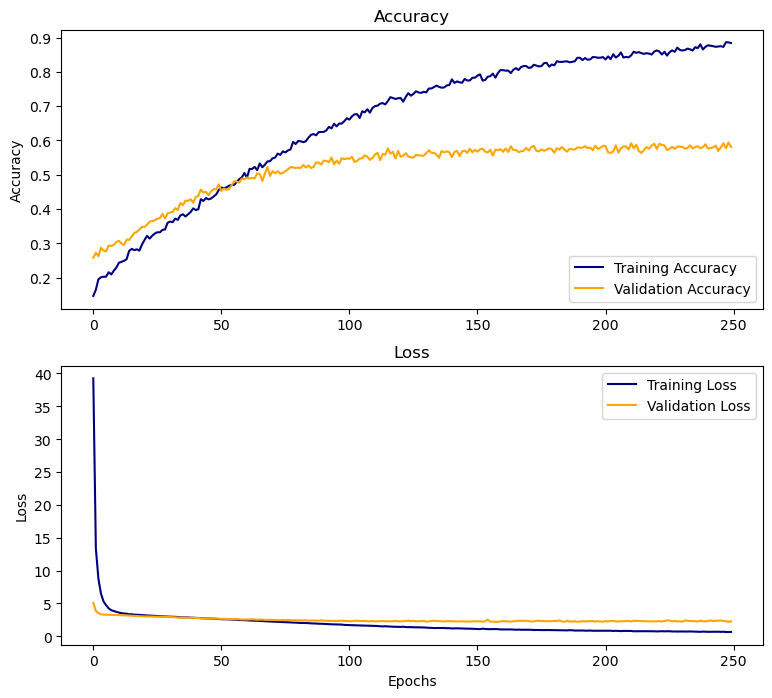

In [79]:
plot_history(hist_dnn)

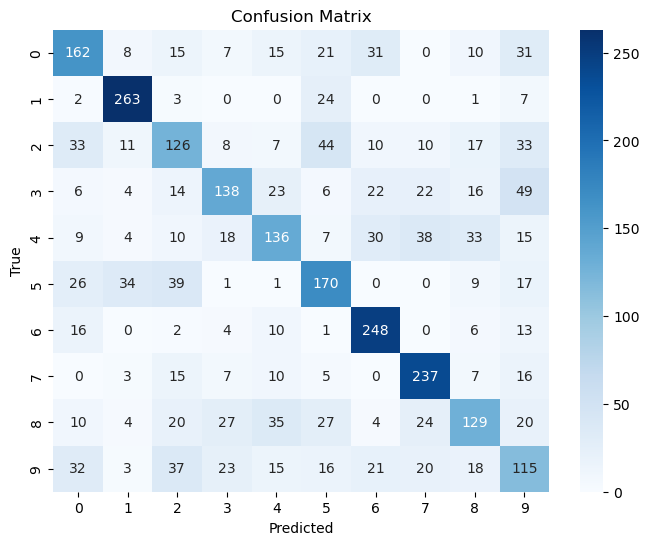

In [81]:
plot_confusion_matrix(model_dnn, X_test_cnn, y_test)

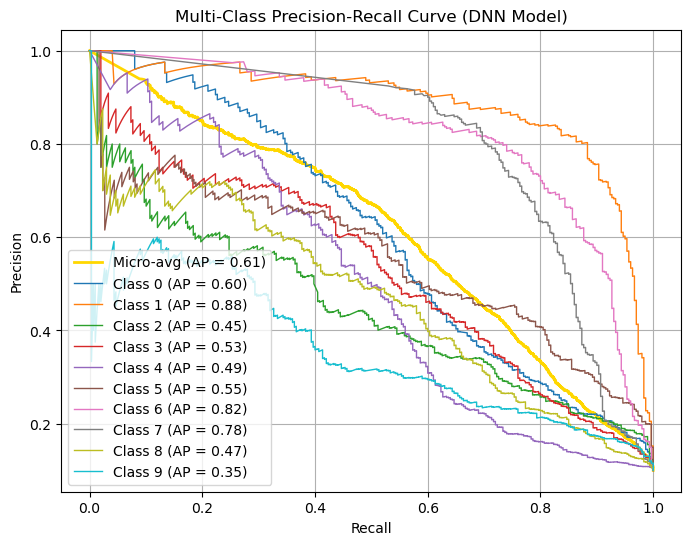

In [82]:
plot_multi_class_pr_curve(model_dnn, X_test_cnn, y_test, "DNN Model")

In [14]:
#building CNN first (without regulatization methods to establish a base performance before iterating through tuning parameters)

In [15]:
model_cnn1 = Sequential()

# Create a convolution block
model_cnn1.add(Conv2D(32, 3, activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn1.add(MaxPooling2D(3, strides=(2,2), padding='same')) # MaxPool the results

# Add another conv block
model_cnn1.add(Conv2D(64, 3, activation='relu'))
model_cnn1.add(MaxPooling2D(3, strides=(2,2), padding='same'))

# Add another conv block
model_cnn1.add(Conv2D(64, 2, activation='relu'))
model_cnn1.add(MaxPooling2D(2, strides=(2,2), padding='same'))

# Flatten output to send through dense layers
model_cnn1.add(Flatten())
model_cnn1.add(Dense(64, activation='relu'))

# output to 10 classes for predictions
model_cnn1.add(Dense(10, activation='softmax'))

In [16]:
model_cnn1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 64)         18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 1, 64)         16448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 1, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 960)              

In [17]:
model_cnn1.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [18]:
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

input_shape = X_train_cnn.shape[1:4]
X_train_cnn.shape 

(4893, 130, 13, 1)

In [ ]:
# Train the model
hist_cnn1 = model_cnn1.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

In [20]:
loss_cnn1, acc_cnn1 = model_cnn1.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn1}")
print(f"Test Accuracy: {acc_cnn1}")

94/94 [==============================] - 1s 2ms/step - loss: 1.9306 - acc: 0.7036
Test Loss: 1.930591344833374
Test Accuracy: 0.7036048173904419


In [21]:

def plot_history(hist):
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)
    axs[0].plot(hist.history["acc"], c='navy', label="Training Accuracy")
    axs[0].plot(hist.history["val_acc"], c='orange', label="Validation Accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")

    axs[1].plot(hist.history["loss"], c='navy', label="Training Loss")
    axs[1].plot(hist.history["val_loss"], c='orange', label="Validation Loss")    
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")
    
    plt.show()

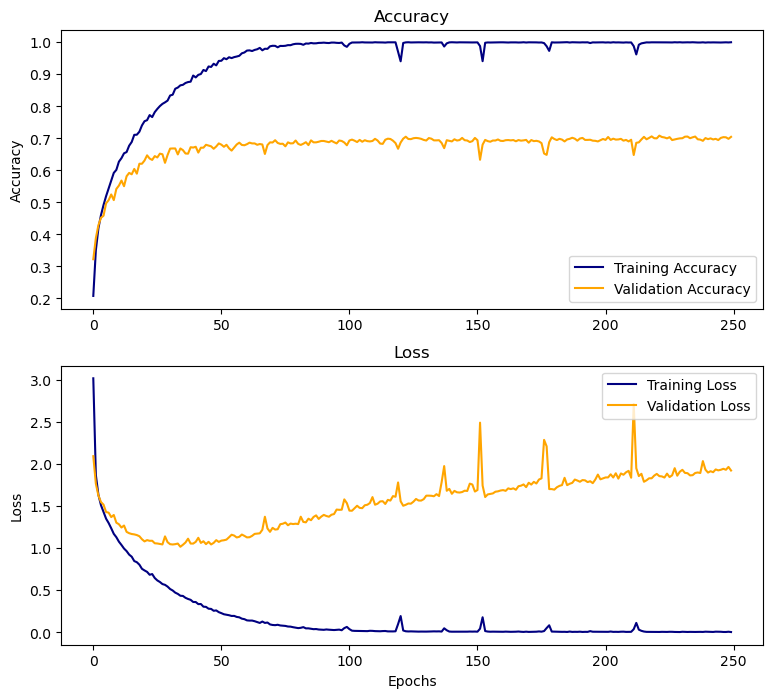

In [22]:
plot_history(hist_cnn1)

In [23]:
#Plots the conusion matrix
def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class indices
    
    # No need to convert y_test if it's already class labels (1D)
    y_true = y_test  # Directly use y_test (assuming it's [n_samples,])
    
    cm = confusion_matrix(y_true, y_pred_classes)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

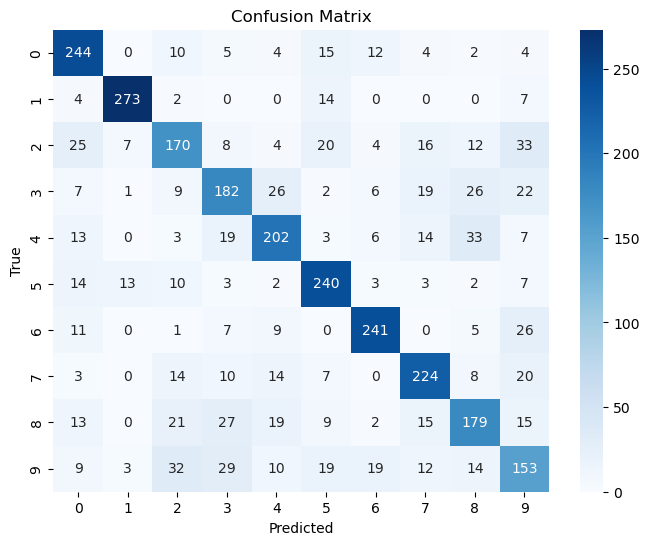

In [24]:
plot_confusion_matrix(model_cnn1, X_test_cnn, y_test)

In [33]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

In [60]:
#plotting Multi-Class Precision-Recall 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

def plot_multi_class_pr_curve(model, X_test, y_test, model_name="Model"):
    # Determine number of classes
    n_classes = len(np.unique(y_test))
    
    # Predict probabilities
    y_pred_prob = model.predict(X_test)
    
    # Binarize labels
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    
    # Initialize dictionaries
    precision = dict()
    recall = dict()
    avg_precision = dict()
    
    # Compute PR curves for each class
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
        avg_precision[i] = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    
    # Micro-average (average over all classes)
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    avg_precision_micro = average_precision_score(y_test_bin, y_pred_prob, average="micro")
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(recall["micro"], precision["micro"], color='gold', lw=2,
             label=f'Micro-avg (AP = {avg_precision_micro:.2f})')
    
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], lw=1,
                 label=f'Class {i} (AP = {avg_precision[i]:.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Multi-Class Precision-Recall Curve ({model_name})')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

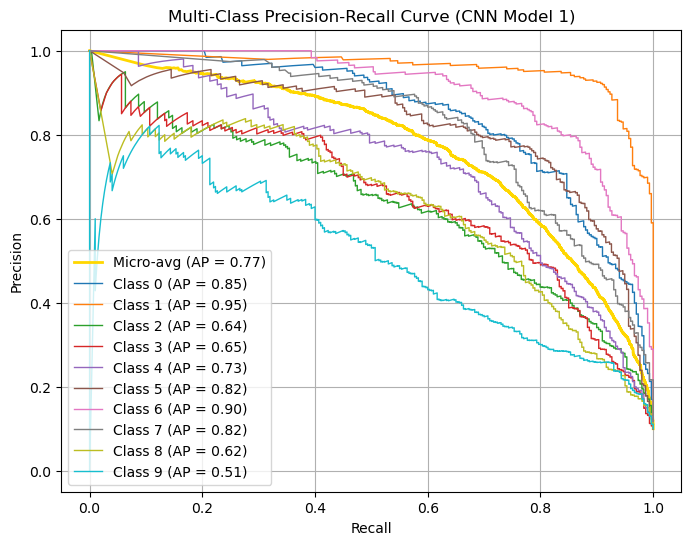

In [61]:
plot_multi_class_pr_curve(model_cnn1, X_test_cnn, y_test, "CNN Model 1")

In [63]:
#building CNN first (with regulatization) this CNN includes: 
#Dropout: Drops some nodes through each epoch to force all nodes to learn all features of the model. This helps reduce overfitting of the model.
#Early Stopping: This stops the model once it has reached a certain threshold of no longer improving. This also helps reduce overfitting.

In [64]:
# Instantiate sequential model
model_cnn2 = Sequential()

# Create a convolution block
model_cnn2.add(Conv2D(32, 3, activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(3, strides=(2,2), padding='same')) # MaxPool the results
model_cnn2.add(Dropout(0.2))

# Add another conv block
model_cnn2.add(Conv2D(64, 3, activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(3, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.1))

# Add another conv block
model_cnn2.add(Conv2D(64, 2, activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(2, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.1))

# Flatten output to send through dense layers
model_cnn2.add(Flatten())
model_cnn2.add(Dense(128, activation='relu'))
model_cnn2.add(Dropout(0.5))

# output to 10 classes for predictions
model_cnn2.add(Dense(10, activation='softmax')) # Softmax activation for multi-class classification

In [65]:
model_cnn2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 11, 32)       320       
_________________________________________________________________
batch_normalization_9 (Batch (None, 128, 11, 32)       128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 6, 32)         0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64, 6, 32)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 62, 4, 64)         18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 62, 4, 64)         256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 2, 64)        

In [66]:
model_cnn2.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [67]:
es_cnn2 = EarlyStopping(monitor='val_loss', patience=20, min_delta=0) 

In [ ]:
hist_cnn2 = model_cnn2.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1,
    callbacks=[es_cnn2]
)

In [69]:
loss_cnn2, acc_cnn2 = model_cnn2.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn2}")
print(f"Test Accuracy: {acc_cnn2}")

94/94 [==============================] - 0s 3ms/step - loss: 0.6967 - acc: 0.7921
Test Loss: 0.6967197060585022
Test Accuracy: 0.7920560836791992


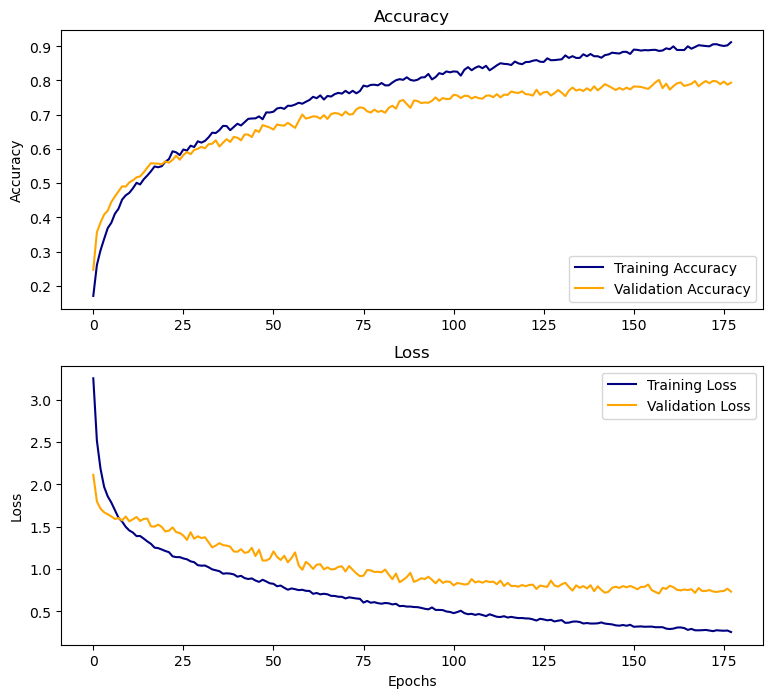

In [70]:
plot_history(hist_cnn2)

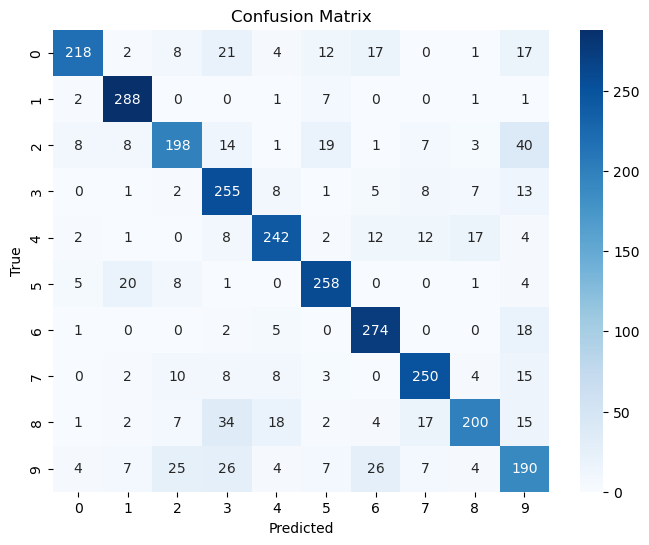

In [71]:
plot_confusion_matrix(model_cnn2, X_test_cnn, y_test)

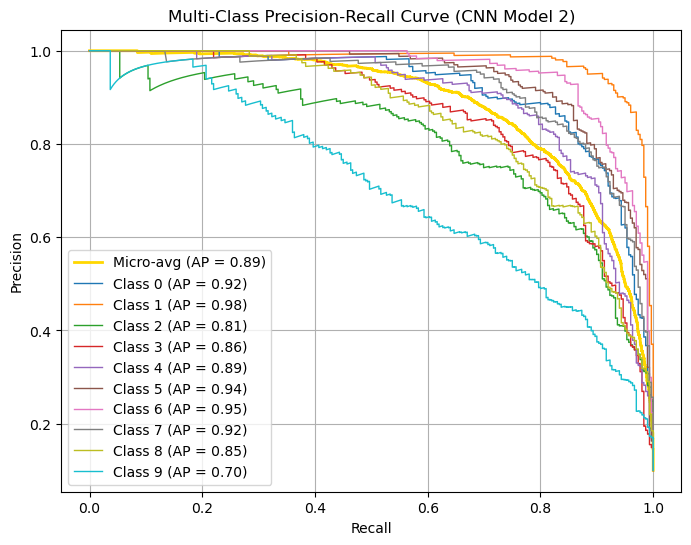

In [72]:
plot_multi_class_pr_curve(model_cnn2, X_test_cnn, y_test, "CNN Model 2")

In [52]:
#this CNN is the same as above but additionally: 
#Increased dropout rates slightly in later layers to prevent overfitting
#Added L2 Weight Regularization 
#progressive kernel sizes (larger early, smaller later) to capture hierarchical features

In [53]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

model_cnn3 = Sequential()

# Block 1: Larger kernel (5x5)
model_cnn3.add(Conv2D(32, 5, activation='relu', input_shape=input_shape))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(3, strides=(2,2), padding='same'))
model_cnn3.add(Dropout(0.3))

# Block 2
model_cnn3.add(Conv2D(64, 3, activation='relu'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(3, strides=(2,2), padding='same'))
model_cnn3.add(Dropout(0.2))

# Block 3
model_cnn3.add(Conv2D(128, 2, activation='relu'))  # Added depth
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(2, strides=(2,2), padding='same'))
model_cnn3.add(Dropout(0.3))

# Global Average Pooling + Regularized Dense
model_cnn3.add(GlobalAveragePooling2D())
model_cnn3.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(Dropout(0.5))

# Output
model_cnn3.add(Dense(10, activation='softmax'))

# Compile with LR decay
optimizer = Adam(learning_rate=0.001, decay=1e-6)
model_cnn3.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [54]:
model_cnn3.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [ ]:
hist_cnn3 = model_cnn3.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1,
    callbacks=[es_cnn2]
)

In [56]:
loss_cnn3, acc_cnn3 = model_cnn3.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn3}")
print(f"Test Accuracy: {acc_cnn3}")

94/94 [==============================] - 0s 3ms/step - loss: 0.5954 - acc: 0.8234
Test Loss: 0.5953521132469177
Test Accuracy: 0.8234312534332275


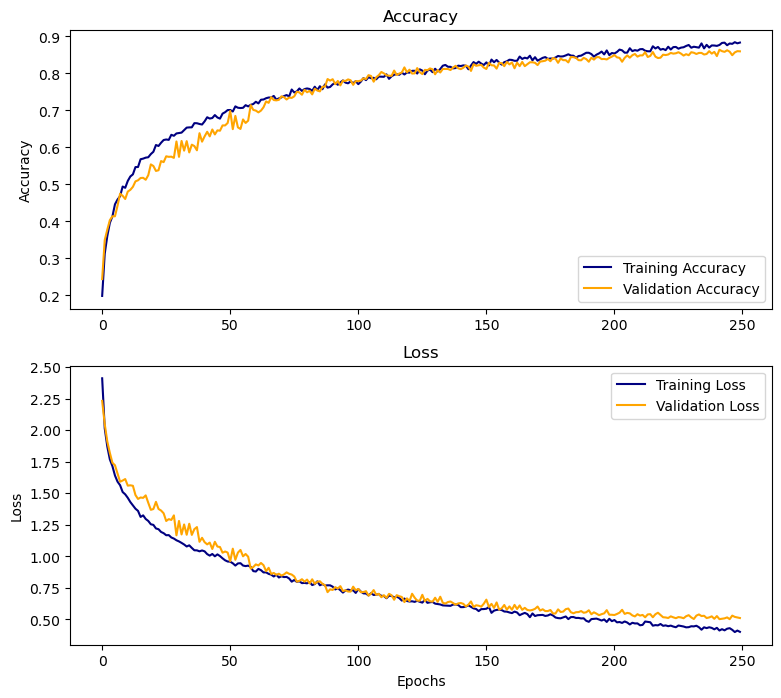

In [57]:
plot_history(hist_cnn2)

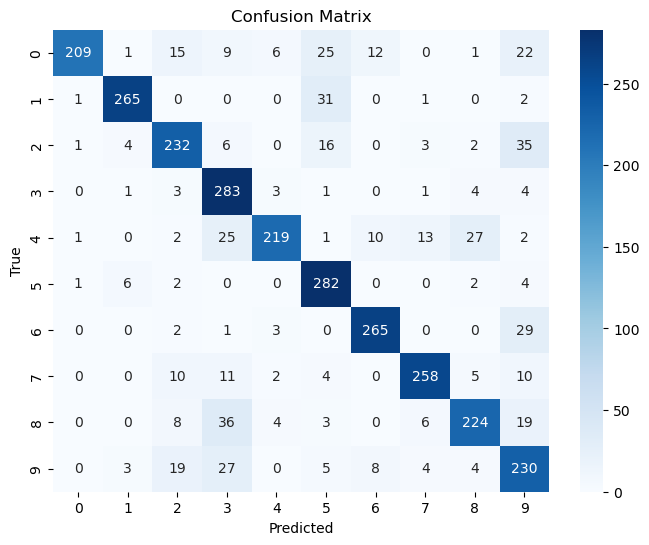

In [59]:
plot_confusion_matrix(model_cnn3, X_test_cnn, y_test)

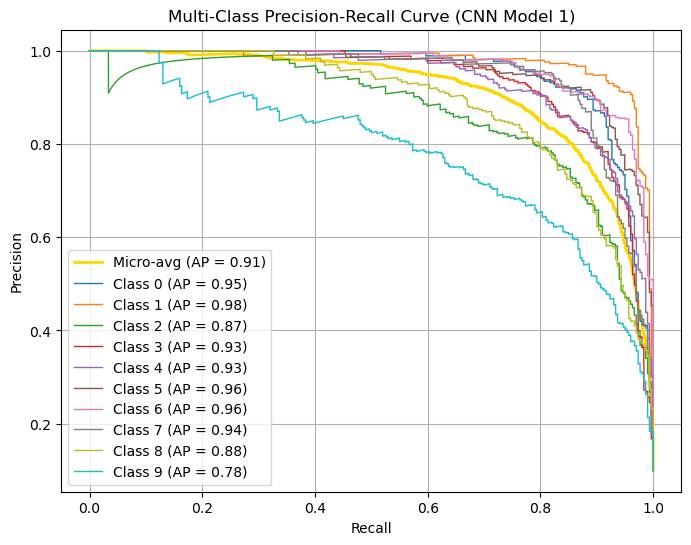

In [62]:
plot_multi_class_pr_curve(model_cnn3, X_test_cnn, y_test, "CNN Model 1")

In [83]:
#implementing data augmentation on the above model
#Data augmentation is a technique to artificially expand your training dataset by applying random but realistic transformations. this helps with:
# overfitting by exposing the model to more varied data.
#Improve generalization since the model learns invariant features.

datagen = ImageDataGenerator(
    rotation_range=15,       # Slight rotations (e.g., ±15 degrees)
    width_shift_range=0.1,   # Horizontal shifts (10% of width)
    height_shift_range=0.1,  # Vertical shifts (10% of height)
    horizontal_flip=True,    # Flip left-right (mirroring)
    zoom_range=0.1,          # Random zoom (up to 10%)
    fill_mode='constant'     # Fill gaps with zeros (avoid artifacts)
)

In [ ]:
es_cnn3 = EarlyStopping(monitor='val_loss', patience=20, min_delta=0) 
hist_cnn4 = model_cnn3.fit(
    datagen.flow(X_train_cnn, y_train),
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=400,
    verbose=1,
    callbacks=[es_cnn3]
)

Epoch 1/400
153/153 [==============================] - 1s 9ms/step - loss: 1.5719 - acc: 0.4488 - val_loss: 1.4638 - val_acc: 0.5393
Epoch 2/400
153/153 [==============================] - 1s 8ms/step - loss: 1.5629 - acc: 0.4496 - val_loss: 1.5108 - val_acc: 0.5265
Epoch 3/400
153/153 [==============================] - 1s 8ms/step - loss: 1.5740 - acc: 0.4486 - val_loss: 1.4729 - val_acc: 0.5398
Epoch 4/400
153/153 [==============================] - 1s 7ms/step - loss: 1.5630 - acc: 0.4527 - val_loss: 1.4044 - val_acc: 0.5622
Epoch 5/400
153/153 [==============================] - 1s 8ms/step - loss: 1.5693 - acc: 0.4539 - val_loss: 1.4589 - val_acc: 0.5389
Epoch 6/400
153/153 [==============================] - 1s 8ms/step - loss: 1.5504 - acc: 0.4613 - val_loss: 1.4696 - val_acc: 0.5370
Epoch 7/400
153/153 [==============================] - 1s 8ms/step - loss: 1.5393 - acc: 0.4613 - val_loss: 1.4744 - val_acc: 0.5441
Epoch 8/400
153/153 [==============================] - 1s 7ms/step - 